In [1]:
import os
# Supress Warnings
import warnings

from tqdm import tqdm

warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
import pandas as pd
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer
from odc.stac import stac_load

In [2]:
# Calculate NDVI
training_data = pd.read_csv("../data_test/training_data_uhi_index.csv")
print(training_data.columns)
training_data['datetime'] = pd.to_datetime(training_data['datetime'], format='%d-%m-%Y %H:%M')
training_data.describe()

Index(['Longitude', 'Latitude', 'datetime', 'UHI Index'], dtype='object')


,Longitude,Latitude,datetime,UHI Index
count,11229.000000,11229.000000,11229,11229.000000
mean,-73.933927,40.808800,2021-07-24 15:34:29.056906240,1.000001
min,-73.994457,40.758792,2021-07-24 15:01:00,0.956122
25%,-73.955703,40.790905,2021-07-24 15:22:00,0.988577
50%,-73.932968,40.810688,2021-07-24 15:36:00,1.000237
75%,-73.909647,40.824515,2021-07-24 15:48:00,1.011176
max,-73.879458,40.859497,2021-07-24 15:59:00,1.046036
std,0.028253,0.023171,NaN,0.016238


In [3]:
# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])
time_window = "2021-07-23/2021-07-25"
height = 100
width = 100

In [4]:
stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

search = stac.search(
    bbox=bounds,
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 30}},
)

In [5]:
items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))
signed_items = [planetary_computer.sign(item).to_dict() for item in items]

This is the number of scenes that touch our region: 1


In [6]:
resolution = 10  # meters per pixel
scale = resolution / 111320.0 # degrees per pixel for crs=4326

In [7]:
data = stac_load(
    items,
    bands=["B01", "B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    crs="EPSG:4326",  # Latitude-Longitude
    resolution=scale,  # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)


In [8]:
df = train_feat = data.to_dataframe().reset_index()
print(df.head())

df['time'] = pd.to_datetime(df['time'])
df['time'] = df['time'].dt.strftime('%d-%m-%Y %H:%M')
display(df)
training_data['datetime'] = pd.to_datetime(training_data['datetime'], format='%d-%m-%Y %H:%M')

    latitude  longitude                    time  spatial_ref  B01  B02   B03  \
0  40.880031 -74.010016 2021-07-24 15:49:11.024         4326  666  639   728   
1  40.880031 -74.009926 2021-07-24 15:49:11.024         4326  666  639   728   
2  40.880031 -74.009837 2021-07-24 15:49:11.024         4326  666  395   579   
3  40.880031 -74.009747 2021-07-24 15:49:11.024         4326  666  562   775   
4  40.880031 -74.009657 2021-07-24 15:49:11.024         4326  710  919  1036   

    B04   B05   B06   B07   B08   B8A   B11   B12  
0   839  1023  2034  2064  1440  2438  1578  1083  
1   839  1023  2034  2064  1440  2438  1578  1083  
2   415   889  1850  2216  2354  2133  1554  1029  
3   688   889  1850  2216  2270  2133  1554  1029  
4  1108  1201  1566  1757  1584  1908  1742  1353  


,latitude,longitude,time,spatial_ref,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12
0,40.880031,-74.010016,24-07-2021 15:49,4326,666,639,728,839,1023,2034,2064,1440,2438,1578,1083
1,40.880031,-74.009926,24-07-2021 15:49,4326,666,639,728,839,1023,2034,2064,1440,2438,1578,1083
2,40.880031,-74.009837,24-07-2021 15:49,4326,666,395,579,415,889,1850,2216,2354,2133,1554,1029
3,40.880031,-74.009747,24-07-2021 15:49,4326,666,562,775,688,889,1850,2216,2270,2133,1554,1029
4,40.880031,-74.009657,24-07-2021 15:49,4326,710,919,1036,1108,1201,1566,1757,1584,1908,1742,1353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2419603,40.750045,-73.860358,24-07-2021 15:49,4326,1175,1412,1362,1602,1858,1940,1908,1588,2050,2202,1989
2419604,40.750045,-73.860268,24-07-2021 15:49,4326,1175,980,1290,1444,1858,1940,1908,1684,2050,2202,1989
2419605,40.750045,-73.860178,24-07-2021 15:49,4326,1182,1202,1326,1416,1530,1557,1903,1842,1797,1909,1721
2419606,40.750045,-73.860088,24-07-2021 15:49,4326,1182,1220,1398,1418,1530,1557,1903,1788,1797,1909,1721


In [9]:
training_data.rename(columns={'Latitude': 'latitude', 'Longitude': 'longitude'}, inplace=True)

In [9]:
training

,Longitude,Latitude,datetime,UHI Index
0,-73.909167,40.813107,2021-07-24 15:53:00,1.030289
1,-73.909187,40.813045,2021-07-24 15:53:00,1.030289
2,-73.909215,40.812978,2021-07-24 15:53:00,1.023798
3,-73.909242,40.812908,2021-07-24 15:53:00,1.023798
4,-73.909257,40.812845,2021-07-24 15:53:00,1.021634
...,...,...,...,...
11224,-73.957050,40.790333,2021-07-24 15:57:00,0.972470
11225,-73.957063,40.790308,2021-07-24 15:57:00,0.972470
11226,-73.957093,40.790270,2021-07-24 15:57:00,0.981124
11227,-73.957112,40.790253,2021-07-24 15:59:00,0.981245


In [10]:
# Function to extract features for a point from a pandas DataFrame
def extract_features_from_dataframe(lat, lon, df):
    # Calculate distances between the point and all rows in df
    df["distance"] = np.sqrt(
        (df["latitude"] - lat) ** 2 + (df["longitude"] - lon) ** 2
    )
    # Find the closest point
    closest_row = df.loc[df["distance"].idxmin()]
    # Return the feature values as a dictionary
    return closest_row.to_dict()

# Iterate over training_data and extract features
features = []
for _, row in training_data.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    features.append(extract_features_from_dataframe(lat, lon, df))

# Combine extracted features with training_data
extracted_features = pd.DataFrame(features)
training_data_with_features = pd.concat([training_data.reset_index(drop=True), extracted_features.reset_index(drop=True)], axis=1)
training_data_with_features = training_data_with_features.loc[:, ~training_data_with_features.columns.duplicated()]

conversion_factor = 111320  # metros por grau (aproximadamente no equador)
training_data_with_features['distance_meters'] = training_data_with_features['distance'] * conversion_factor




KeyError: 'latitude'

In [11]:
# Exemplo: Criação de NDVI e SAVI
training_data_with_features['NDVI'] = (training_data_with_features['B08'] - training_data_with_features['B04']) / (training_data_with_features['B08'] + training_data_with_features['B04'] + 1e-6)
L = 0.5
training_data_with_features['SAVI'] = ((training_data_with_features['B08'] - training_data_with_features['B04']) * (1 + L)) / (training_data_with_features['B08'] + training_data_with_features['B04'] + L + 1e-6)

# Criação de NDBI
training_data_with_features['NDBI'] = (training_data_with_features['B11'] - training_data_with_features['B08']) / (training_data_with_features['B11'] + training_data_with_features['B08'] + 1e-6)

# Criação de MNDWI
training_data_with_features['MNDWI'] = (training_data_with_features['B03'] - training_data_with_features['B11']) / (training_data_with_features['B03'] + training_data_with_features['B11'] + 1e-6)

# Criação de EVI
training_data_with_features['EVI'] = 2.5 * (training_data_with_features['B08'] - training_data_with_features['B04']) / (training_data_with_features['B08'] + 6 * training_data_with_features['B04'] - 7.5 * training_data_with_features['B02'] + 1)

In [163]:
print(training_data_with_features.columns)
training_data_with_features = training_data_with_features.drop(columns=['datetime', 'time'], axis=1, errors = 'ignore')
print(training_data_with_features.std())

Index(['longitude', 'latitude', 'UHI Index', 'spatial_ref', 'B01', 'B02',
       'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12',
       'distance', 'distance_meters', 'NDVI', 'SAVI', 'NDBI', 'MNDWI', 'EVI',
       'day', 'airtemp'],
      dtype='object')


TypeError: float() argument must be a string or a real number, not 'datetime.date'

In [13]:
training_data_with_features_x = training_data_with_features

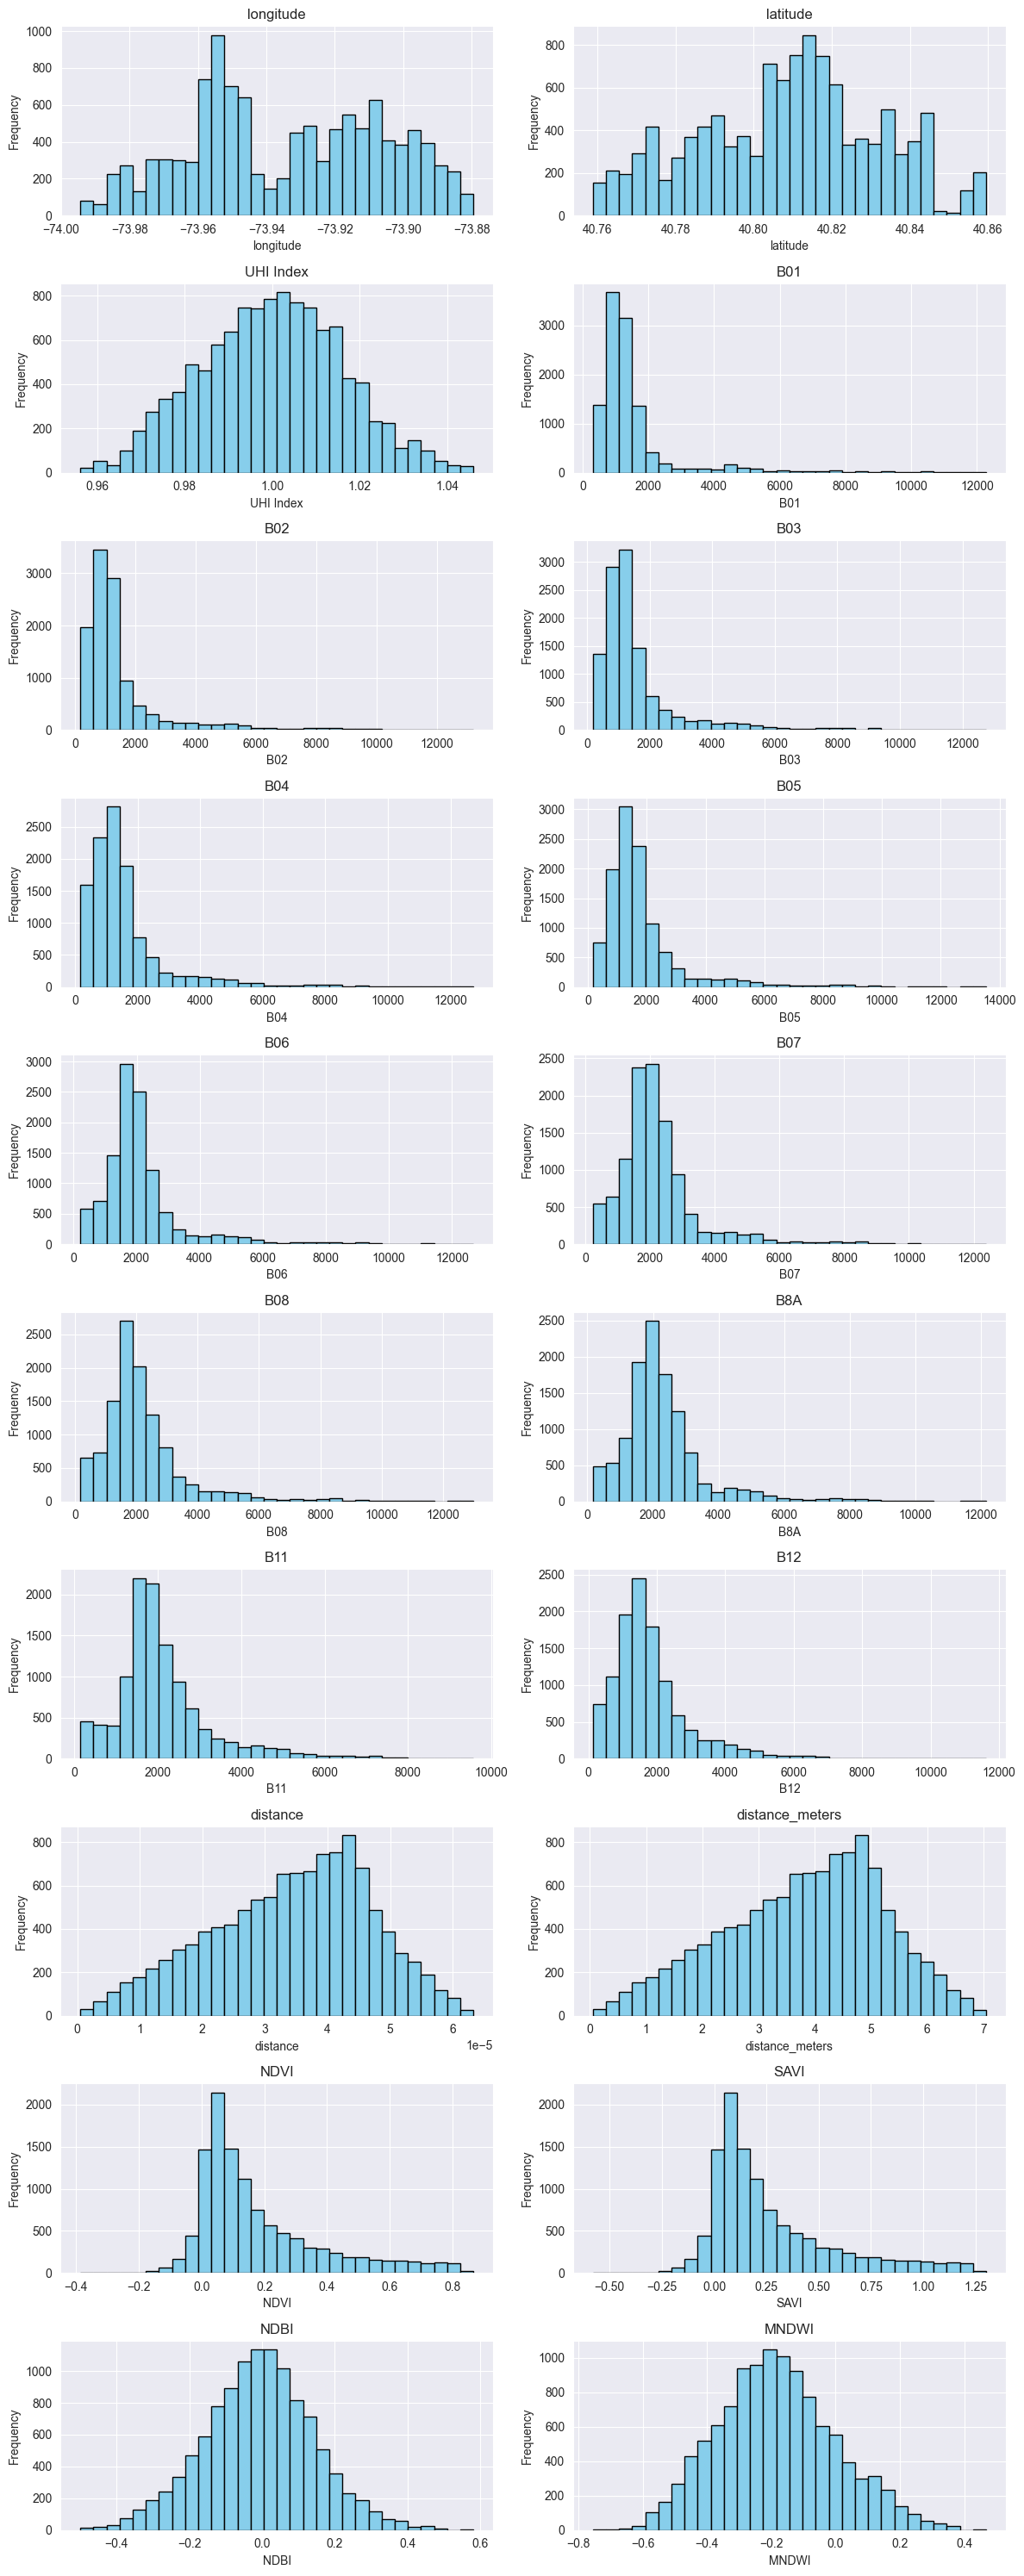

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Remove unnecessary columns
df1 = training_data_with_features.drop(columns=["datetime", "time", "spatial_ref", "EVI"],
                                         errors='ignore')
df_plot = df1.copy()

# Get the list of features (columns) to plot
features = df_plot.columns.tolist()
n_features = len(features)

# Set number of columns per row for the subplots
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Flatten axes in case it's a 2D array

for i, feature in enumerate(features):
    series = df_plot[feature].dropna()

    # If the first element is iterable (but not a string), flatten the series
    if series.size > 0:
        sample = series.iloc[0]
        if hasattr(sample, '__iter__') and not isinstance(sample, str):
            data = np.concatenate(series.values)
        else:
            data = series.values
    else:
        data = series.values

    # Plot histogram for the feature
    axes[i].hist(data, bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Frequency")

# Hide any empty subplots (if the number of features is odd)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


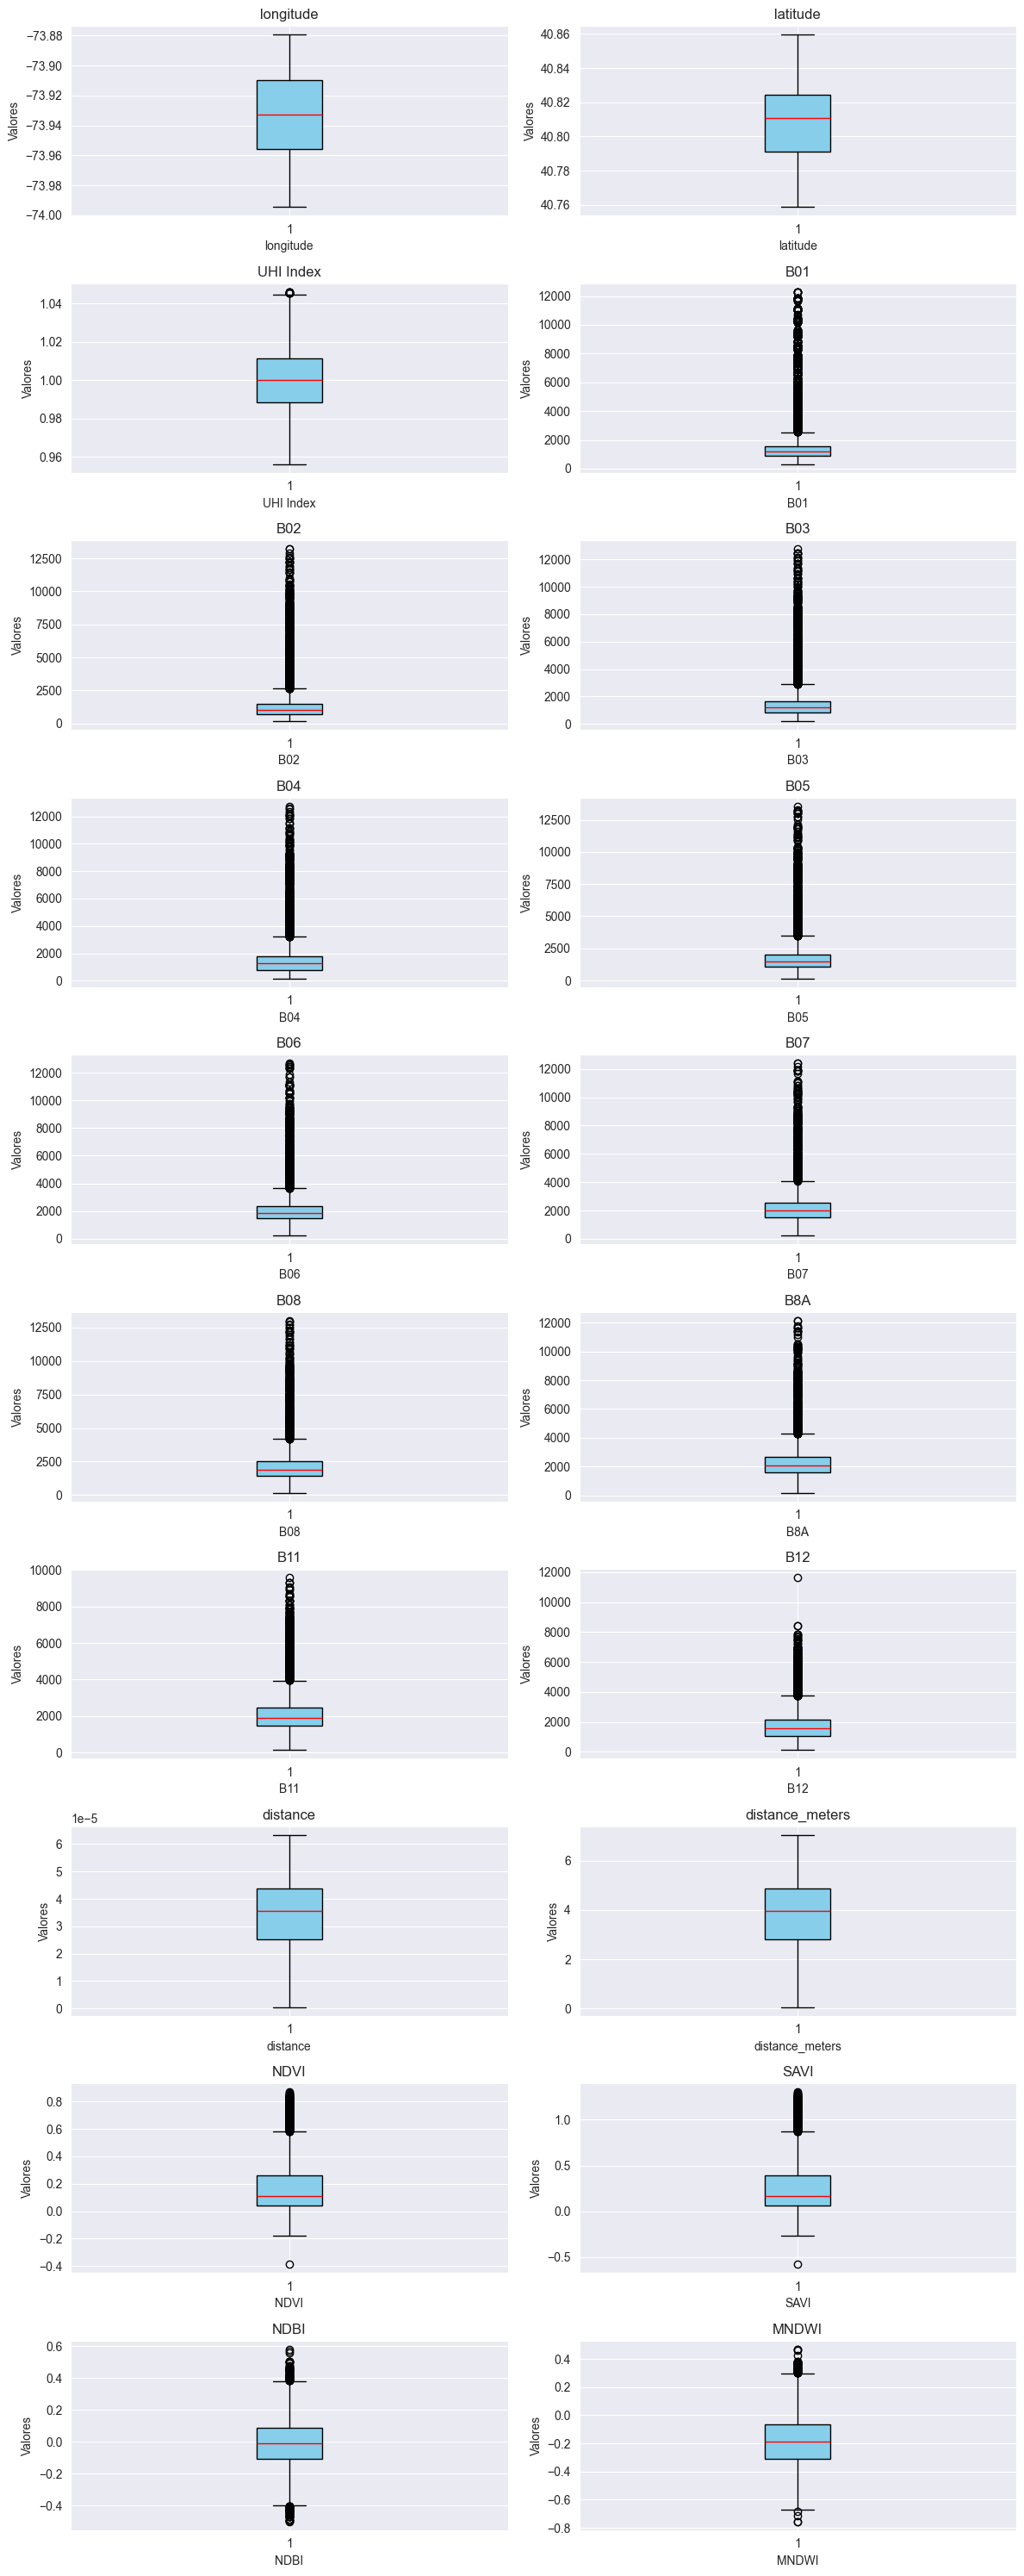

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Remover colunas indesejadas para manter apenas as features desejadas
df1 = training_data_with_features.drop(columns=["datetime",
                        "time",
                        "spatial_ref",
                        "EVI"],
                       errors='ignore')

# Utilize df1 (ou outro DataFrame final com as features) para plotar
df_plot = df1.copy()

# Obter a lista de features
features = df_plot.columns.tolist()
n_features = len(features)

# Definir número de colunas por linha para os subplots
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

# Criar figura e subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Se os eixos estiverem em array 2D, transforma em 1D

# Loop para criar o boxplot de cada feature
for i, feature in enumerate(features):
    data = df_plot[feature].dropna()  # Remover NaNs para um boxplot mais limpo
    axes[i].boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Valores")

# Esconder subplots vazios (caso o número de features seja ímpar)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<Axes: >

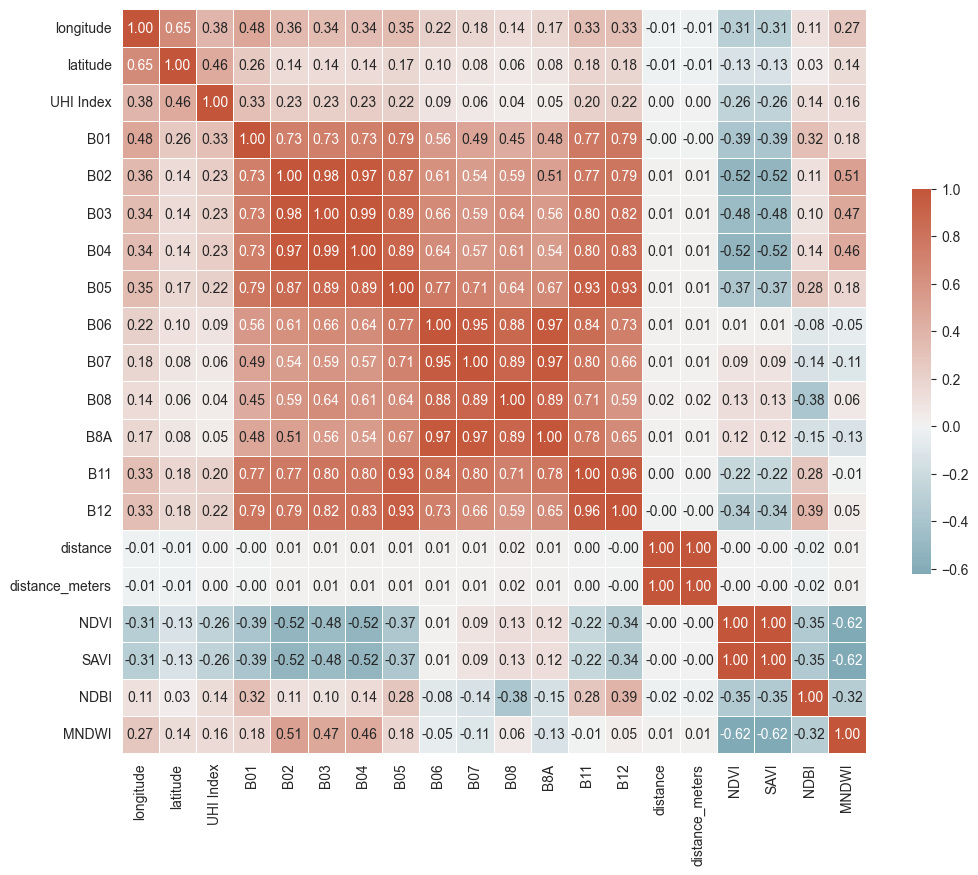

In [16]:
## corr matrix heat map
import seaborn as sns

# Remover colunas indesejadas para manter apenas as features desejadas
df1 = training_data_with_features.drop(columns=["datetime",
                        "time",
                        "spatial_ref",
                        "EVI"],
                       errors='ignore')

# Utilize df1 (ou outro DataFrame final com as features) para plotar
df_plot = df1.copy()

# Calcular a matriz de correlação spearman
corr = df_plot.corr(method='spearman')

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))

# Definir o mapa de cores
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plotar o mapa de calor
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

In [120]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, factor=3):
    print(df)
    df.reset_index(drop=True)
    df_clean = df.copy()
    # Get list of numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Keep rows within the bounds
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Example usage:
# Assuming df is your DataFrame
df_clean_factor3 = remove_outliers_iqr(df1, factor=3)
df_clean_factor4 = remove_outliers_iqr(df1, factor=4)
df_clean_factor5 = remove_outliers_iqr(df1, factor=5)
df_clean_factor2 = remove_outliers_iqr(df1, factor=2)
print("Data shape before outlier removal:", df1.shape)
print("Data shape after outlier removal:", df_clean_factor3.shape)


       longitude   latitude  UHI Index  B01   B02   B03   B04   B05   B06  \
0     -73.909167  40.813107   1.030289  846  1042  1036  1036  1272  1502   
1     -73.909187  40.813045   1.030289  846   583   818   709  1054  1668   
2     -73.909215  40.812978   1.023798  846   583   818   709  1054  1668   
3     -73.909242  40.812908   1.023798  846   581   733   657  1054  1668   
4     -73.909257  40.812845   1.021634  846   655   744   745  1021  1728   
...          ...        ...        ...  ...   ...   ...   ...   ...   ...   
11224 -73.957050  40.790333   0.972470  481   747   860   813   990  2382   
11225 -73.957063  40.790308   0.972470  481   540   742   610   990  2382   
11226 -73.957093  40.790270   0.981124  481   540   742   610   990  2382   
11227 -73.957112  40.790253   0.981245  481   540   742   610   990  2382   
11228 -73.957128  40.790237   0.983408  481   607   742   753  1027  2256   

        B07   B08   B8A   B11   B12  distance  distance_meters      NDVI  \

In [18]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # Necessário para ativar o IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import KNNImputer


def replace_outliers_with_nan(df, factor=3):
    # Cria uma cópia do DataFrame para não modificar o original
    df_clean = df.copy()
    # Seleciona as colunas numéricas
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Substitui por NaN os valores que estão fora do intervalo [lower_bound, upper_bound]
        df_clean.loc[(df_clean[col] < lower_bound) | (df_clean[col] > upper_bound), col] = np.nan

    return df_clean

# Exemplo de uso:
# Suponha que df1 seja seu DataFrame original
df_transformed_imputer = replace_outliers_with_nan(df1, factor=3)
print("Formato dos dados antes e depois (deve permanecer o mesmo):", df1.shape, df_transformed_imputer.shape)
print("Número de NaNs por coluna após a transformação:")
print(df_transformed_imputer.isna().sum())

mice_imputer = IterativeImputer(estimator=BayesianRidge(), max_iter=20, random_state=42)
df_imputed_mice = pd.DataFrame(mice_imputer.fit_transform(df_transformed_imputer), columns=df_transformed_imputer.columns)
knn_imputer = KNNImputer(n_neighbors=10)
df_imputed_knn = pd.DataFrame(knn_imputer.fit_transform(df_transformed_imputer), columns=df_transformed_imputer.columns)

Formato dos dados antes e depois (deve permanecer o mesmo): (11229, 20) (11229, 20)
Número de NaNs por coluna após a transformação:
longitude            0
latitude             0
UHI Index            0
B01                883
B02                811
B03                695
B04                545
B05                575
B06                542
B07                322
B08                318
B8A                277
B11                276
B12                170
distance             0
distance_meters      0
NDVI                 0
SAVI                 0
NDBI                 0
MNDWI                0
dtype: int64


<Axes: >

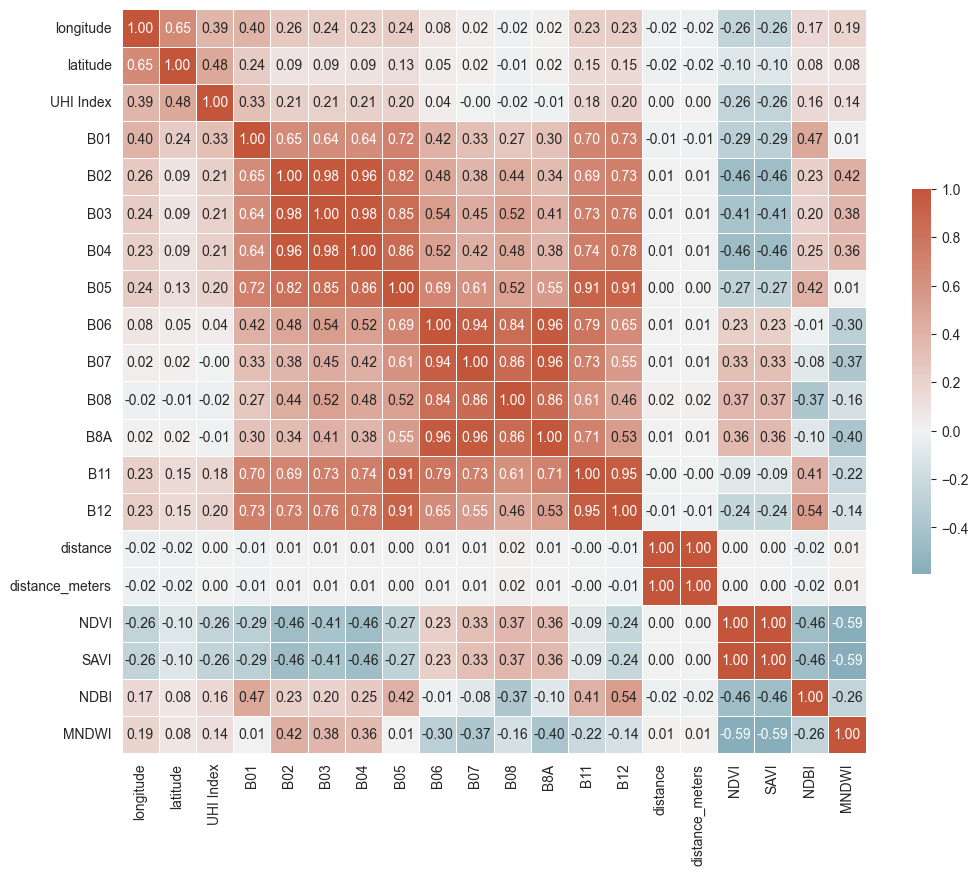

In [19]:
## corr matrix heat map
import seaborn as sns

# Utilize df1 (ou outro DataFrame final com as features) para plotar
df_plot = df_clean_factor3.copy()

# Calcular a matriz de correlação spearman
corr = df_plot.corr(method='spearman')

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))

# Definir o mapa de cores
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plotar o mapa de calor
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

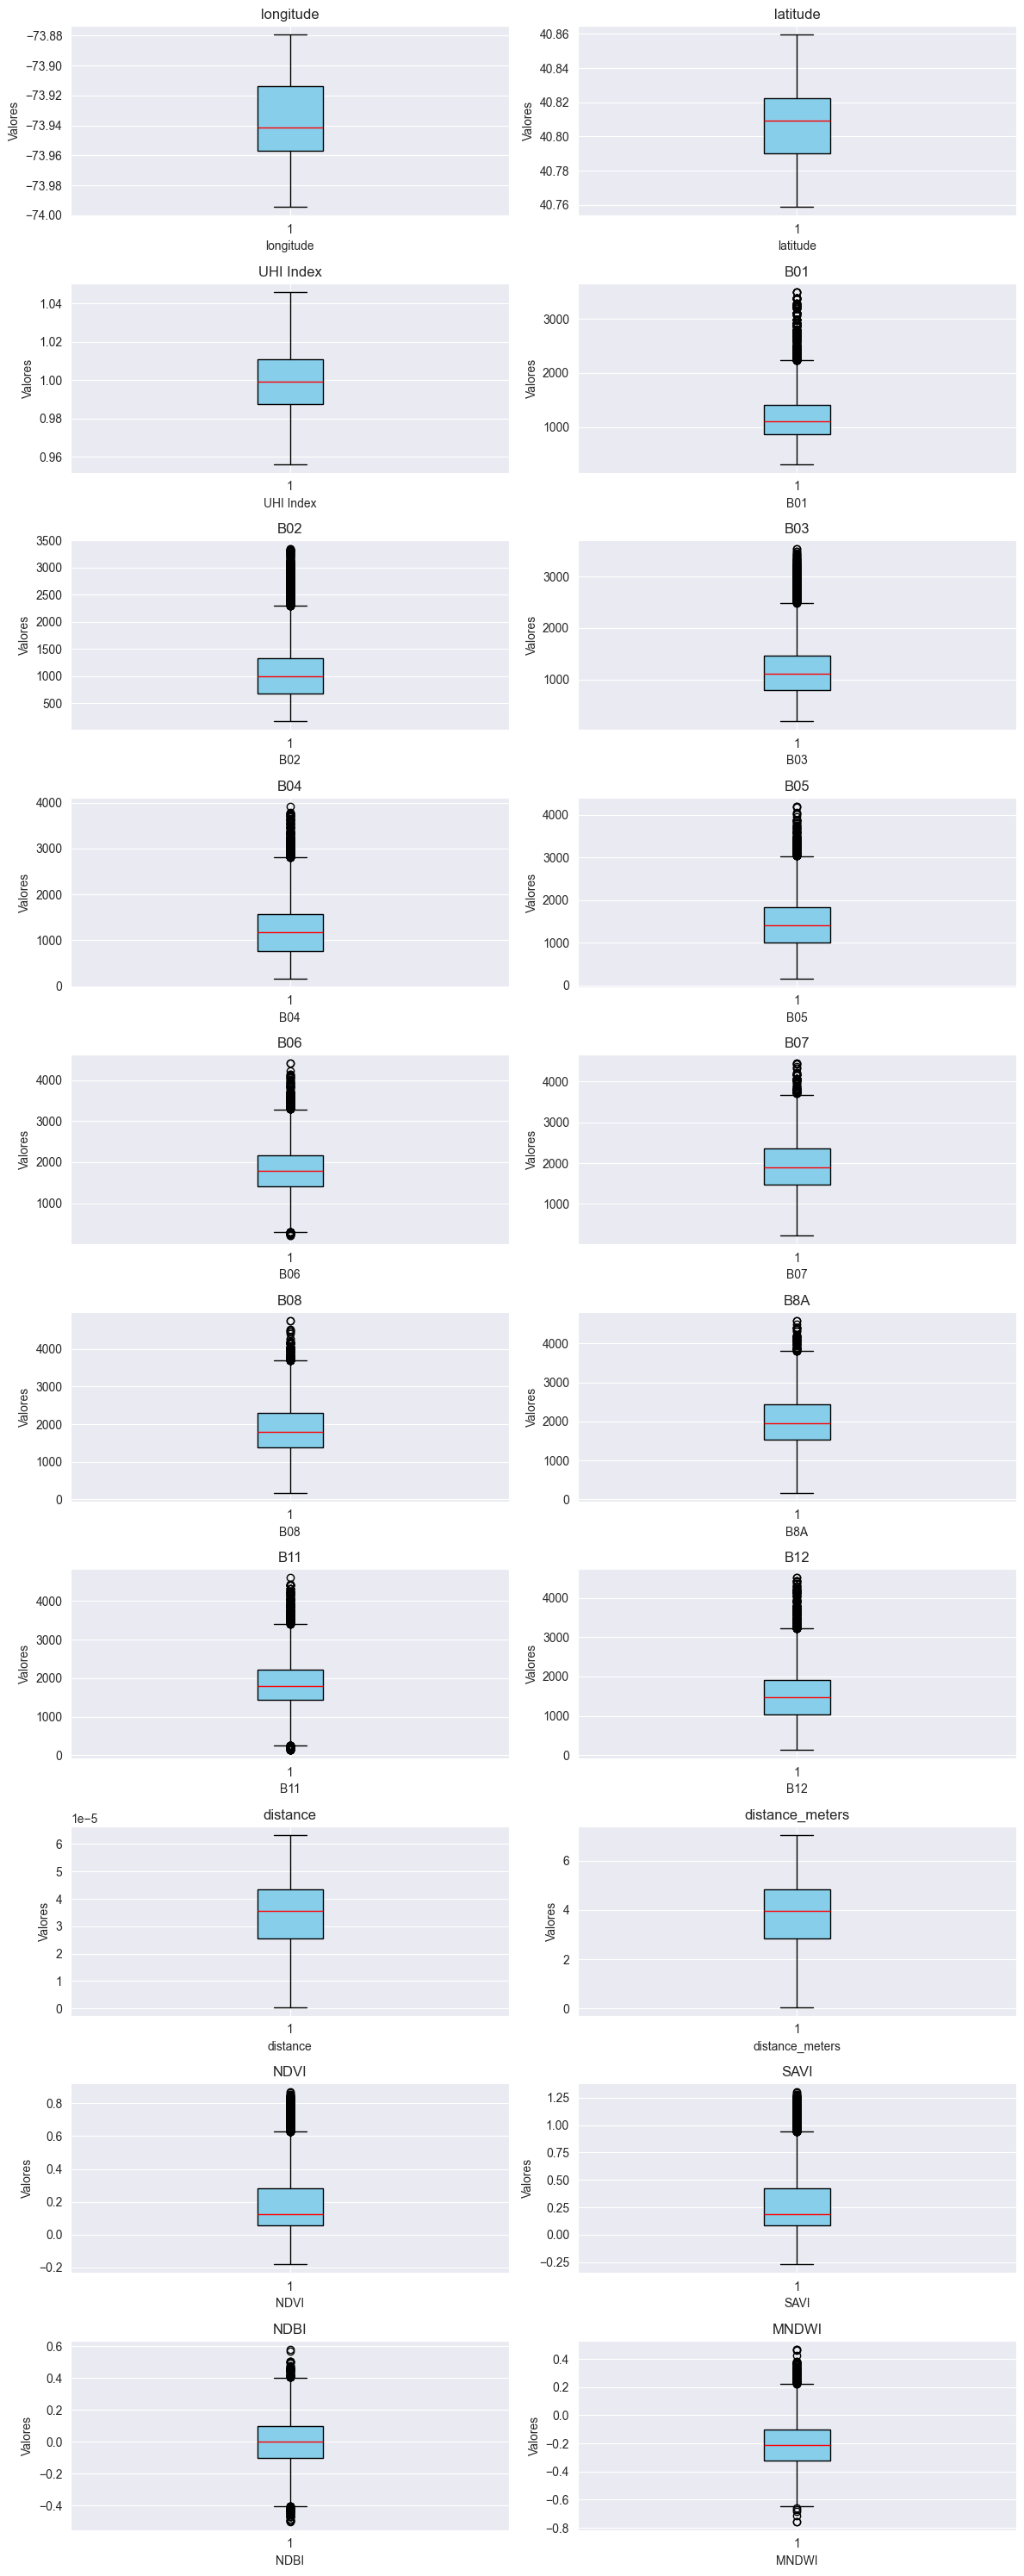

In [20]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df_clean_factor3.copy()

# Obter a lista de features
features = df_plot.columns.tolist()
n_features = len(features)

# Definir número de colunas por linha para os subplots
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

# Criar figura e subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Se os eixos estiverem em array 2D, transforma em 1D

# Loop para criar o boxplot de cada feature
for i, feature in enumerate(features):
    data = df_plot[feature].dropna()  # Remover NaNs para um boxplot mais limpo
    axes[i].boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Valores")

# Esconder subplots vazios (caso o número de features seja ímpar)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [21]:
import pandas as pd
import numpy as np

def remove_outliers_iqr(df, factor=3):
    df_clean = df.copy()
    # Get list of numeric columns
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()

    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR

        # Keep rows within the bounds
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Example usage:
# Assuming df is your DataFrame
df_clean_factor5 = remove_outliers_iqr(df1, factor=1.5)
print("Data shape before outlier removal:", df1.shape)
print("Data shape after outlier removal:", df_clean_factor5.shape)


Data shape before outlier removal: (11229, 20)
Data shape after outlier removal: (7790, 20)


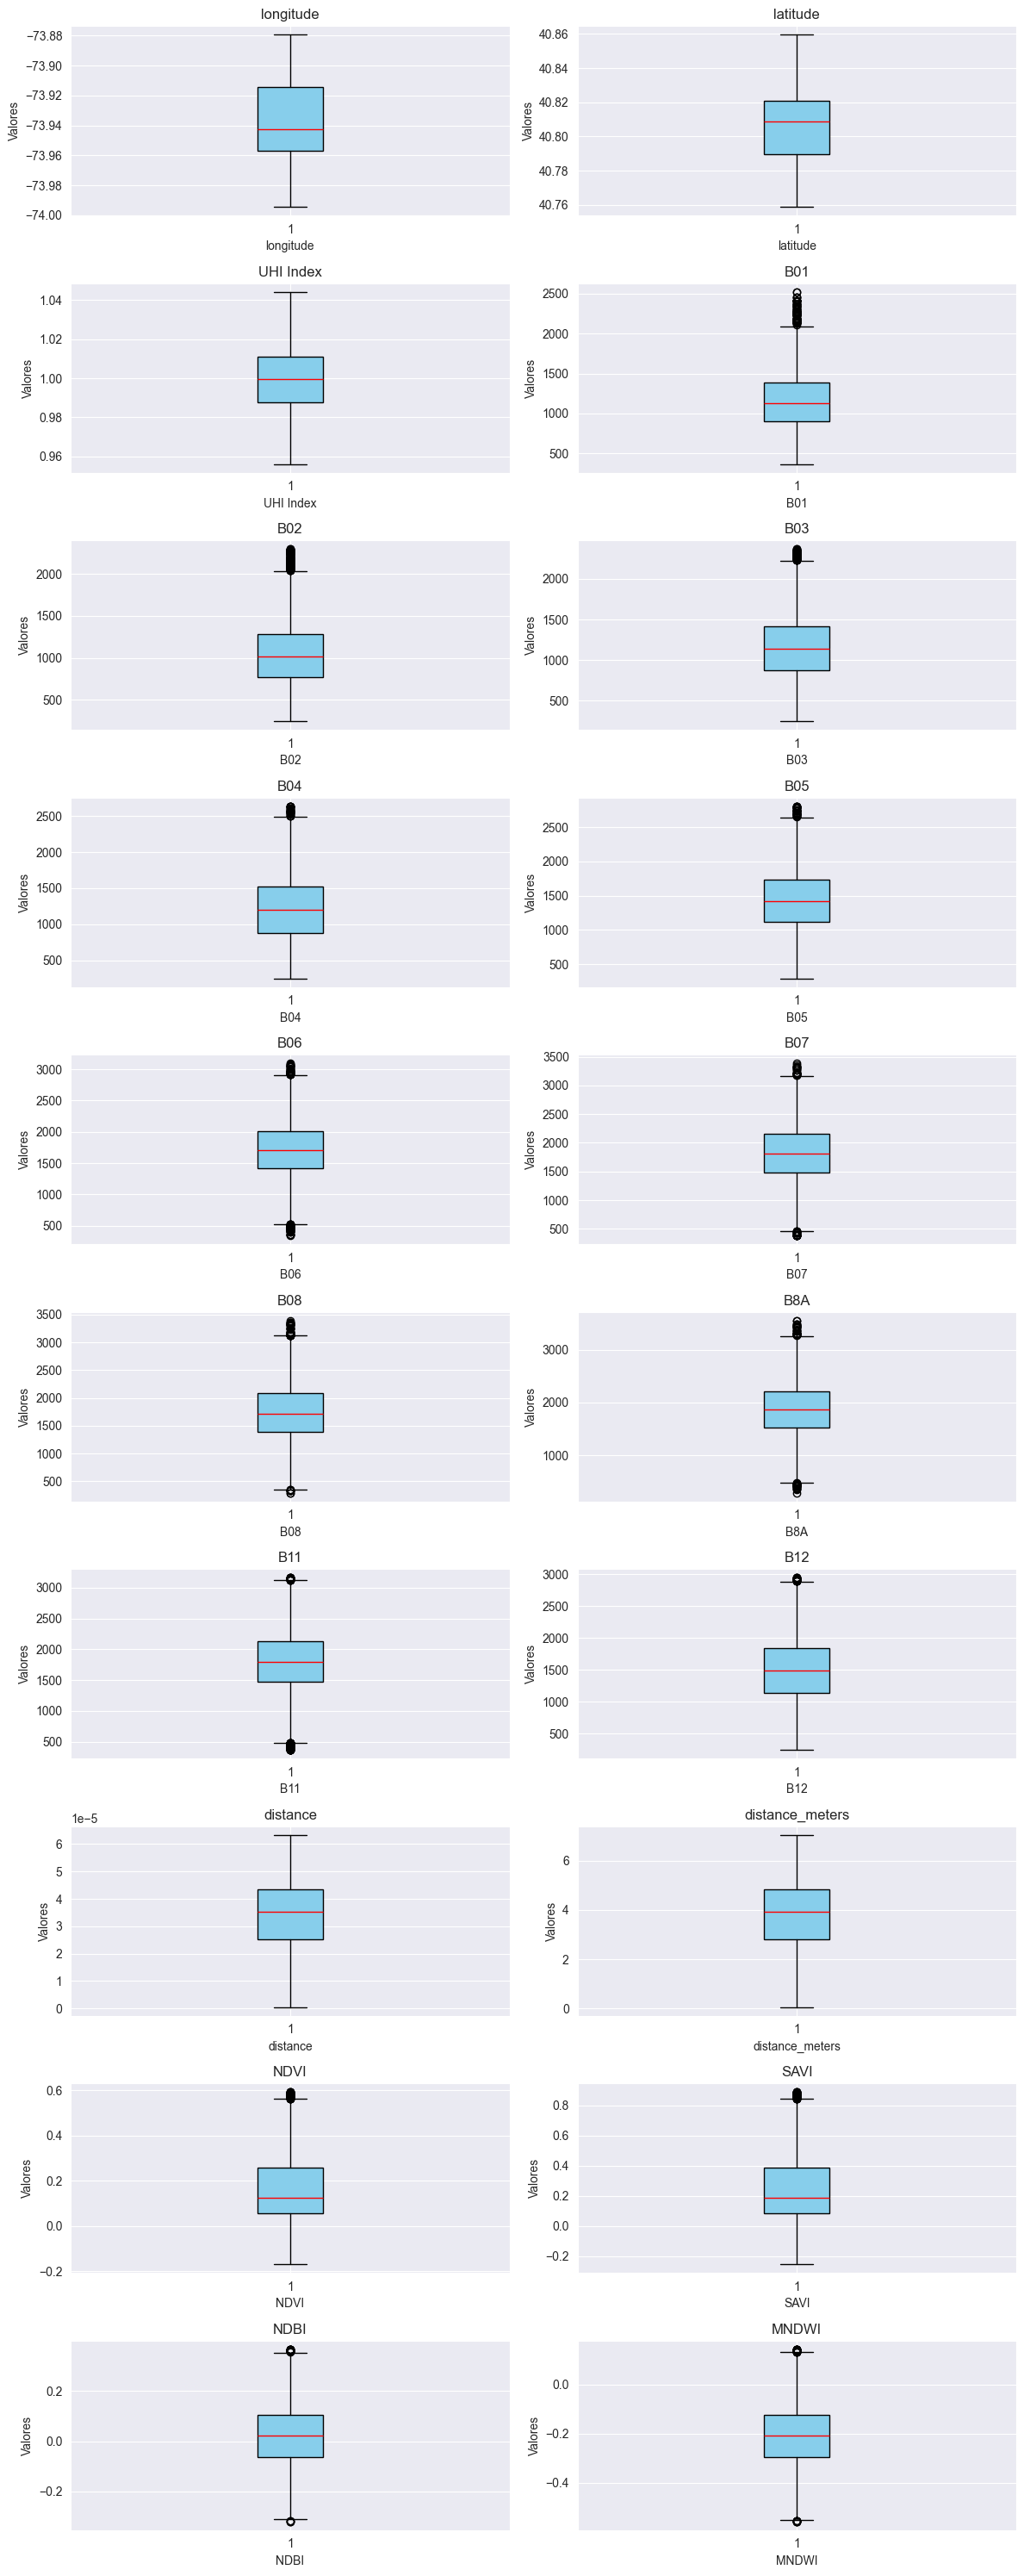

In [22]:
import matplotlib.pyplot as plt
import numpy as np

df_plot = df_clean_factor5.copy()

# Obter a lista de features
features = df_plot.columns.tolist()
n_features = len(features)

# Definir número de colunas por linha para os subplots
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))

# Criar figura e subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 3))
axes = axes.flatten()  # Se os eixos estiverem em array 2D, transforma em 1D

# Loop para criar o boxplot de cada feature
for i, feature in enumerate(features):
    data = df_plot[feature].dropna()  # Remover NaNs para um boxplot mais limpo
    axes[i].boxplot(data, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='skyblue', color='black'),
                    medianprops=dict(color='red'))
    axes[i].set_title(feature)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Valores")

# Esconder subplots vazios (caso o número de features seja ímpar)
for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


<Axes: >

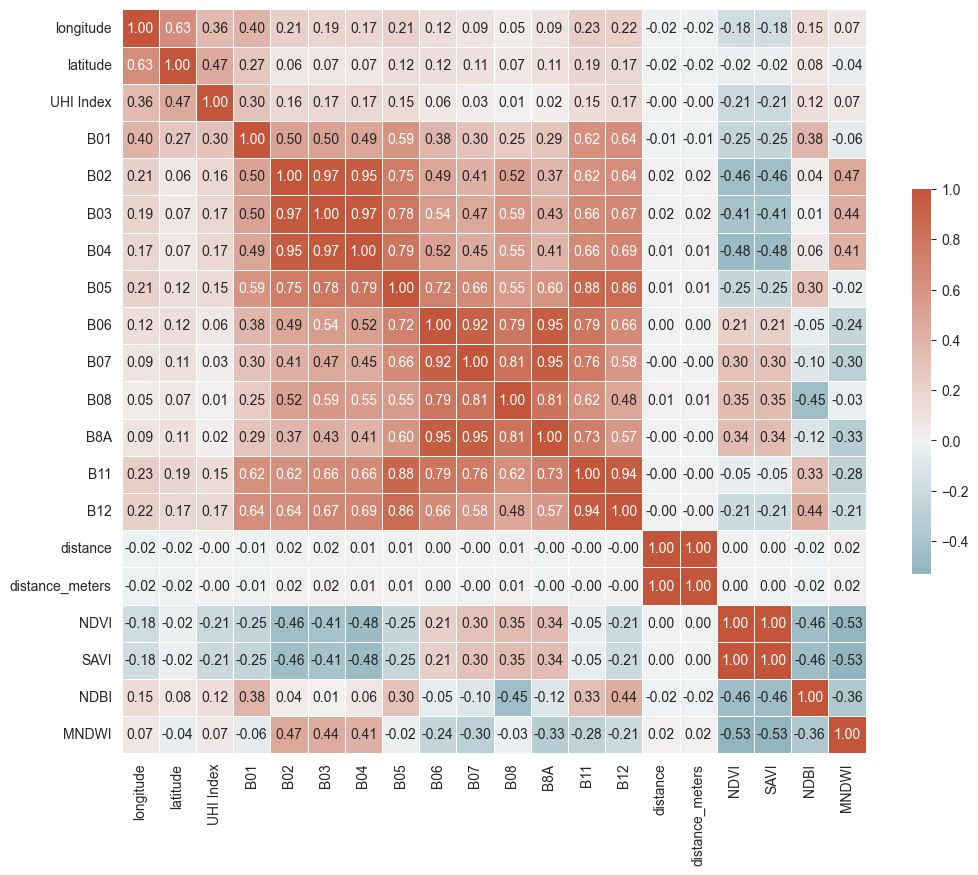

In [23]:
## corr matrix heat map
import seaborn as sns

# Utilize df1 (ou outro DataFrame final com as features) para plotar
df_plot = df_clean_factor5.copy()

# Calcular a matriz de correlação spearman
corr = df_plot.corr(method='spearman')

# Criar um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))

# Definir o mapa de cores
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Plotar o mapa de calor
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})

In [136]:
import pandas as pd
import joblib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# ------------------------------
# 1. Carregar Dados e Pré-processamento
# ------------------------------
# Carregue seu dataset (ajuste o caminho conforme necessário)

# data = training_data_with_features
# data = df_clean_factor5.copy()
data = df_clean_factor3.copy()
# data = df_imputed_mice
# data = df_imputed_knn
# data = df_clean_factor4.copy()
# data = df_clean_factor5.copy()
# data = df_clean_factor2.copy()

# Remova as colunas irrelevantes
cols_to_drop = ["latitude", "longitude","datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Defina a variável target e remova colunas duplicadas de coordenadas, se houver
target = "UHI Index"

X = data.drop(target, axis=1)
y = data[target]

# Divida os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


# ------------------------------
# 2. Construção do Pipeline
# ------------------------------
# Pipeline com:
# - VarianceThreshold: remove features com variância < 0.01
# - SelectFromModel: seleciona features com importância acima da média (usando ExtraTreesRegressor)
# - SelectKBest: escolhe as 5 melhores features com f_regression
# - StandardScaler: padroniza os dados
# - Modelo: ExtraTreesRegressor com hiperparâmetros otimizados
pipeline = Pipeline([
    # ("variance_threshold", VarianceThreshold(threshold=0.01)),
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.99*mean"
    )),
    ("scaler", RobustScaler()),
    # ("select_kbest", SelectKBest(score_func=f_regression, k=5)),
    ("model", ExtraTreesRegressor(random_state=42, n_estimators=600, max_depth=100, min_samples_split=2))
])

# ------------------------------
# 3. Treinamento e Avaliação
# ------------------------------
print("Treinando o pipeline...")
pipeline.fit(X_train, y_train)

# selected_mask = pipeline.named_steps['select_from_model'].get_support()
# selected_features = X_train.columns[selected_mask]
# print("Features usadas na predição:", selected_features.tolist())

# Avaliação no conjunto de teste
y_pred = pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

pipeline.fit(X, y)

Treinando o pipeline...
Test R²: 0.7953
Test MAPE: 0.41%


Pipeline(steps=[('select_from_model',
                 SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=300,
                                                               random_state=42),
                                 threshold='0.99*mean')),
                ('scaler', RobustScaler()),
                ('model',
                 ExtraTreesRegressor(max_depth=100, n_estimators=600,
                                     random_state=42))])

In [137]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assuming df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build the Pipeline with Polynomial Features
# ------------------------------
# Pipeline includes:
# - SelectFromModel: select features with importance above threshold
# - PolynomialFeatures: generate interaction and squared features (degree 2)
# - RobustScaler: scale the data
# - Model: ExtraTreesRegressor with optimized hyperparameters
pipeline = Pipeline([
    # You can include VarianceThreshold if needed, here we keep just SelectFromModel:
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.99*mean"
    )),
    # Add polynomial features (degree=2) without adding a constant term (bias)
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    ("scaler", RobustScaler()),
    ("model", ExtraTreesRegressor(random_state=42, n_estimators=600, max_depth=100, min_samples_split=2))
])

# ------------------------------
# 3. Train and Evaluate the Pipeline
# ------------------------------
print("Training the pipeline with Polynomial Features...")
pipeline.fit(X_train, y_train)

# If you want to inspect the selected features from the select_from_model step:
selected_mask = pipeline.named_steps['select_from_model'].get_support()
selected_features = X_train.columns[selected_mask]
print("Features used in prediction (before poly expansion):", selected_features.tolist())

# Evaluate on test set
y_pred = pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

pipeline.fit(X, y)
# ------------------------------
# Optionally, save the trained pipeline
# ------------------------------
model_filename = "trained_pipeline_poly.pkl"
joblib.dump(pipeline, model_filename)
print("Pipeline saved as:", model_filename)


Training the pipeline with Polynomial Features...
Features used in prediction (before poly expansion): ['B01', 'B05', 'B12']
Test R²: 0.7679
Test MAPE: 0.43%
Pipeline saved as: trained_pipeline_poly.pkl


In [54]:
model_filename = "trained_model_pipeline.pkl"
joblib.dump(pipeline, model_filename)
print("Pipeline salvo como '{}'".format(model_filename))

Pipeline salvo como 'trained_model_pipeline.pkl'


In [55]:
df_clean_factor5.columns

Index(['longitude', 'latitude', 'UHI Index', 'B01', 'B02', 'B03', 'B04', 'B05',
       'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'distance', 'distance_meters',
       'NDVI', 'SAVI', 'NDBI', 'MNDWI'],
      dtype='object')

In [64]:
sub_temp = pd.read_csv('../data/Submission_template.csv')
sub_temp.rename(columns={"Latitude": "latitude", "Longitude": "longitude"}, inplace=True)
features = []
for _, row in sub_temp.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    features.append(extract_features_from_dataframe(lat, lon, train_feat))

val_features = pd.DataFrame(features)
val_data_with_features = pd.concat([sub_temp.reset_index(drop=True), val_features.reset_index(drop=True)], axis=1)
val_data_with_features = val_data_with_features.loc[:, ~val_data_with_features.columns.duplicated()]
val_data_with_features

,longitude,latitude,UHI Index,time,spatial_ref,B01,B02,B03,B04,B05,B06,B07,B08,B8A,B11,B12,distance
0,-73.971665,40.788763,NaN,24-07-2021 15:49,4326,811,459,617,432,984,2089,2405,2502,2552,1474,893,0.000007
1,-73.971928,40.788875,NaN,24-07-2021 15:49,4326,1208,667,800,745,1112,2076,2248,2288,2445,1751,1188,0.000023
2,-73.967080,40.789080,NaN,24-07-2021 15:49,4326,899,955,1052,1188,979,995,1158,1246,1056,1101,763,0.000042
3,-73.972550,40.789082,NaN,24-07-2021 15:49,4326,1193,1132,1364,1512,1866,1939,2076,1774,2196,2521,2346,0.000040
4,-73.969697,40.787953,NaN,24-07-2021 15:49,4326,1097,1506,1642,1688,1294,2204,2411,2834,2601,2248,1848,0.000015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,24-07-2021 15:49,4326,1474,1086,1382,1474,1824,1553,1995,1578,1828,2421,2089,0.000025
1036,-73.931033,40.833178,NaN,24-07-2021 15:49,4326,1014,576,883,965,2034,2393,2701,2664,2679,2019,1201,0.000045
1037,-73.934647,40.854542,NaN,24-07-2021 15:49,4326,1268,1466,1608,1762,2040,2040,2246,1992,2184,2119,1682,0.000023
1038,-73.917223,40.815413,NaN,24-07-2021 15:49,4326,1890,1066,1244,1368,2302,2587,2621,2094,2723,3066,2379,0.000029


In [65]:
# Exemplo: Criação de NDVI e SAVI
val_data_with_features['NDVI'] = (val_data_with_features['B08'] - val_data_with_features['B04']) / (val_data_with_features['B08'] + val_data_with_features['B04'] + 1e-6)
L = 0.5
val_data_with_features['SAVI'] = ((val_data_with_features['B08'] - val_data_with_features['B04']) * (1 + L)) / (val_data_with_features['B08'] + val_data_with_features['B04'] + L + 1e-6)

# Criação de NDBI
val_data_with_features['NDBI'] = (val_data_with_features['B11'] - val_data_with_features['B08']) / (val_data_with_features['B11'] + val_data_with_features['B08'] + 1e-6)

# Criação de MNDWI
val_data_with_features['MNDWI'] = (val_data_with_features['B03'] - val_data_with_features['B11']) / (val_data_with_features['B03'] + val_data_with_features['B11'] + 1e-6)

# Criação de EVI
val_data_with_features['EVI'] = 2.5 * (val_data_with_features['B08'] - val_data_with_features['B04']) / (val_data_with_features['B08'] + 6 * val_data_with_features['B04'] - 7.5 * val_data_with_features['B02'] + 1)

In [66]:
# val_data_with_features = val_data_with_features[['longitude', 'latitude', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06','B07', 'B08', 'B8A', 'B11', 'B12']]
copy_val_data = val_data_with_features[['B01', 'B02', 'B03', 'B04', 'B05', 'B06','B07', 'B08', 'B8A', 'B11', 'B12', 'NDVI', 'SAVI', 'NDBI', 'MNDWI']].copy()
pred_vals = pipeline.predict(copy_val_data)

In [67]:
pred_vals

array([0.96165106, 0.96273292, 0.98604624, ..., 1.04122768, 1.00648864,
       1.03617902], shape=(1040,))

In [68]:
data_to_send = pd.DataFrame()
data_to_send['UHI Index'] = pred_vals
data_to_send['Latitude'] = val_data_with_features['latitude']
data_to_send['Longitude'] = val_data_with_features['longitude']

data_to_send = data_to_send[['Longitude', 'Latitude', 'UHI Index']]
data_to_send.to_csv('../outputs/poly_predicted_values.csv', index=False)

(array([  4.,   5.,   1.,   7.,  15.,  24.,  30.,  34.,  33.,  44.,  46.,
         73.,  92.,  67.,  61.,  58.,  91., 123.,  59.,  42.,  44.,  27.,
         15.,  13.,  10.,  13.,   3.,   2.,   3.,   1.]),
 array([0.95720342, 0.96015249, 0.96310155, 0.96605061, 0.96899968,
        0.97194874, 0.9748978 , 0.97784686, 0.98079593, 0.98374499,
        0.98669405, 0.98964312, 0.99259218, 0.99554124, 0.99849031,
        1.00143937, 1.00438843, 1.0073375 , 1.01028656, 1.01323562,
        1.01618469, 1.01913375, 1.02208281, 1.02503188, 1.02798094,
        1.03093   , 1.03387907, 1.03682813, 1.03977719, 1.04272626,
        1.04567532]),
 <BarContainer object of 30 artists>)

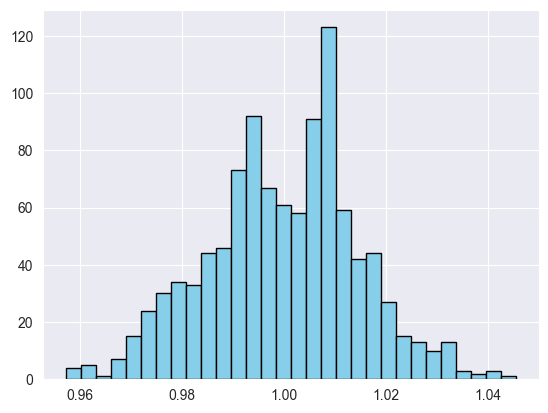

In [69]:
## need an histogram of np.array
import matplotlib.pyplot as plt
import numpy as np

# Create a histogram of the predicted values
plt.hist(pred_vals, bins=30, color='skyblue', edgecolor='black')


In [70]:
data_to_send = pd.DataFrame()
data_to_send['UHI Index'] = pred_vals
data_to_send['Latitude'] = val_data_with_features['latitude']
data_to_send['Longitude'] = val_data_with_features['longitude']

data_to_send = data_to_send[['Longitude', 'Latitude', 'UHI Index']]
data_to_send.to_csv('../outputs/predicted_values.csv', index=False)

#TESTES!!!

In [82]:
temperature_data = pd.read_csv('../data/hyperlocal_temperature_monitoring.csv')
temperature_data

,sensor_id,airtemp,day,hour,latitude,longitude,year,install_type,borough,ntacode,location
0,Bk-BR_01,71.189000,2018-06-15,1,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,POINT(-73.91691035 40.66620508)
1,Bk-BR_01,70.243333,2018-06-15,2,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,POINT(-73.91691035 40.66620508)
2,Bk-BR_01,69.392667,2018-06-15,3,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,POINT(-73.91691035 40.66620508)
3,Bk-BR_01,68.263167,2018-06-15,4,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,POINT(-73.91691035 40.66620508)
4,Bk-BR_01,67.114000,2018-06-15,5,40.666205,-73.91691,2018,Street Tree,Brooklyn,BK81,POINT(-73.91691035 40.66620508)
...,...,...,...,...,...,...,...,...,...,...,...
2097145,Q-CH_26,78.346667,2019-09-07,15,40.699578,-73.73876,2019,Light Pole,Queens,QN33,POINT(-73.73875976 40.69957777)
2097146,Q-CH_26,79.517167,2019-09-07,16,40.699578,-73.73876,2019,Light Pole,Queens,QN33,POINT(-73.73875976 40.69957777)
2097147,Q-CH_26,77.203667,2019-09-07,17,40.699578,-73.73876,2019,Light Pole,Queens,QN33,POINT(-73.73875976 40.69957777)
2097148,Q-CH_26,75.696000,2019-09-07,18,40.699578,-73.73876,2019,Light Pole,Queens,QN33,POINT(-73.73875976 40.69957777)


In [83]:
temperature_data['day'] = pd.to_datetime(temperature_data['day'])
temperature_data['day'] = temperature_data['day'].dt.date
mean_airtemp_by_location = temperature_data.groupby(['day', 'latitude', 'longitude'])['airtemp'].mean().reset_index()

print(mean_airtemp_by_location)


              day   latitude  longitude    airtemp
0      2018-06-15  40.646738 -73.951234  72.139967
1      2018-06-15  40.646877 -73.946154  71.774659
2      2018-06-15  40.647370 -73.945400  72.687326
3      2018-06-15  40.647410 -73.948200  72.555236
4      2018-06-15  40.647446 -73.951205  72.260609
...           ...        ...        ...        ...
87495  2019-10-15  40.855890 -73.910900  58.996024
87496  2019-10-15  40.855990 -73.912400  59.714460
87497  2019-10-15  40.856271 -73.909516  58.380929
87498  2019-10-15  40.856330 -73.908500  62.366873
87499  2019-10-15  40.856406 -73.915026  59.246262

[87500 rows x 4 columns]


<Axes: >

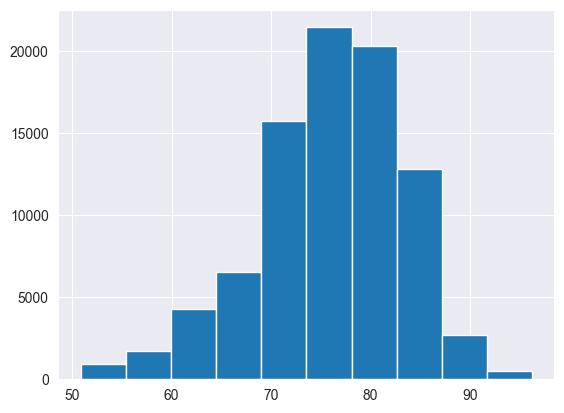

In [84]:
mean_airtemp_by_location['airtemp'].hist()

In [99]:


# Function to extract features for a point from a pandas DataFrame
def extract_features_from_dataframe(lat, lon, df):
    # Calculate distances between the point and all rows in df
    df["distance"] = np.sqrt(
        (df["latitude"] - lat) ** 2 + (df["longitude"] - lon) ** 2
    )
    # Find the closest point
    closest_row = df.loc[df["distance"].idxmin()]
    # Return the feature values as a dictionary
    return closest_row.to_dict()

# Iterate over training_data and extract features
features = []
for _, row in training_data.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    features.append(extract_features_from_dataframe(lat, lon, mean_airtemp_by_location))

features
# Combine extracted features with training_data
extracted_temperature = pd.DataFrame(features)
training_data_with_features = pd.concat([training_data_with_features_x.reset_index(drop=True), extracted_temperature.reset_index(drop=True)], axis=1)

training_data_with_features = training_data_with_features.loc[:, ~training_data_with_features.columns.duplicated()]
training_data_with_features


training_data_with_features.to_csv('../data/training_data_with_features_corr.csv', index=False)

Colunas disponíveis: ['longitude', 'latitude', 'UHI Index', 'spatial_ref', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'distance', 'distance_meters', 'NDVI', 'SAVI', 'NDBI', 'MNDWI', 'EVI', 'day', 'airtemp']
Matriz de correlação:
                 longitude  latitude  UHI Index       B01       B02       B03  \
longitude         1.000000  0.650135   0.375915  0.476767  0.364829  0.344340   
latitude          0.650135  1.000000   0.455201  0.259185  0.139297  0.138985   
UHI Index         0.375915  0.455201   1.000000  0.327084  0.230660  0.226925   
B01               0.476767  0.259185   0.327084  1.000000  0.730866  0.729658   
B02               0.364829  0.139297   0.230660  0.730866  1.000000  0.984153   
B03               0.344340  0.138985   0.226925  0.729658  0.984153  1.000000   
B04               0.336030  0.138932   0.229234  0.729015  0.973605  0.985587   
B05               0.347150  0.167169   0.219911  0.786837  0.865326  0.885516   
B06     

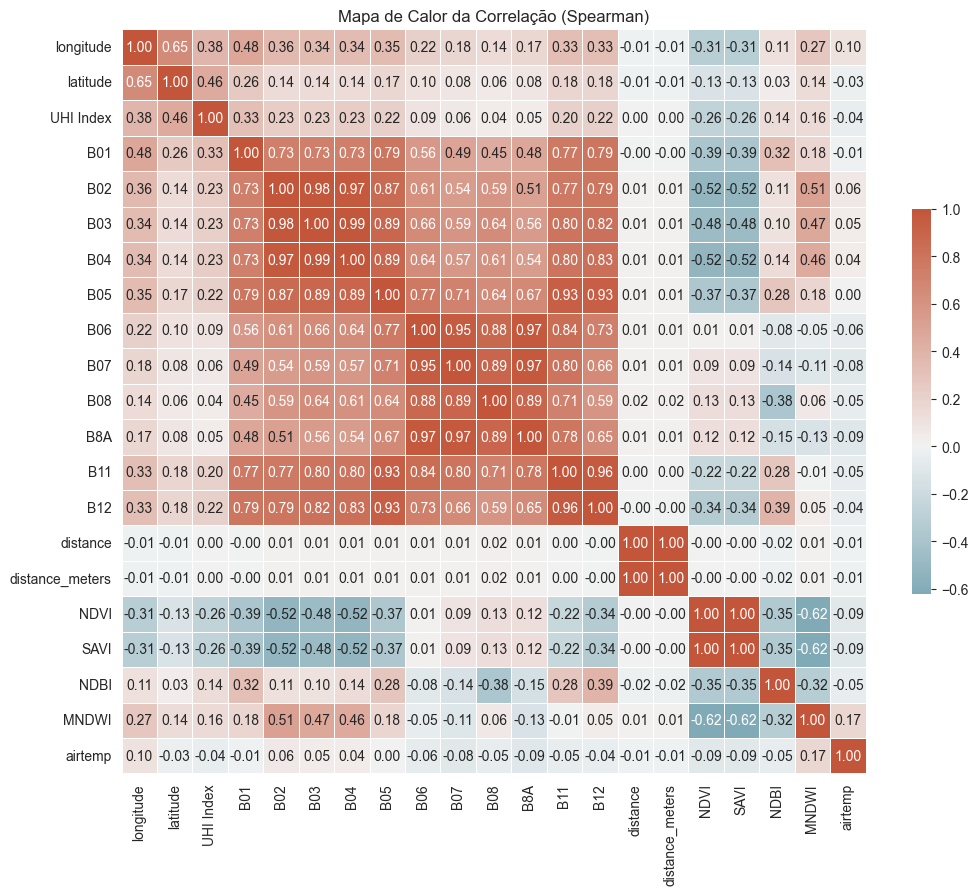

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Suponha que training_data_with_features já esteja definido
# Exemplo de impressão das colunas:
print("Colunas disponíveis:", training_data_with_features.columns.tolist())

# Crie uma cópia do DataFrame para o cálculo da correlação
df_plot = training_data_with_features.copy()

# Remova as colunas não numéricas ou que não deseja incluir na correlação
cols_to_drop = ['datetime', 'time', 'spatial_ref', 'EVI', 'day']
df_plot = df_plot.drop(columns=cols_to_drop, errors='ignore')

# Converta todas as colunas para valores numéricos (valores não convertíveis se tornam NaN)
df_plot = df_plot.apply(pd.to_numeric, errors='coerce')

# Calcule a matriz de correlação usando o método Spearman
corr = df_plot.corr(method='spearman')
print("Matriz de correlação:")
print(corr)

# Crie um mapa de calor da matriz de correlação
plt.figure(figsize=(12, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, annot=True, fmt=".2f", center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title("Mapa de Calor da Correlação (Spearman)")
plt.show()


In [38]:
df_clean_factor_temp = remove_outliers_iqr(training_data_with_features, factor=3)
df_clean_factor_temp

,longitude,latitude,UHI Index,spatial_ref,B01,B02,B03,B04,B05,B06,...,B12,distance,distance_meters,NDVI,SAVI,NDBI,MNDWI,EVI,day,airtemp
1,-73.909187,40.813045,1.030289,4326,846,583,818,709,1054,1668,...,991,0.000048,5.373992,0.510866,0.766167,-0.198358,-0.283399,1.786490,2019-06-15,77.419315
2,-73.909215,40.812978,1.023798,4326,846,583,818,709,1054,1668,...,991,0.000040,4.414653,0.510866,0.766167,-0.198358,-0.283399,1.786490,2019-06-15,77.419315
3,-73.909242,40.812908,1.023798,4326,846,581,733,657,1054,1668,...,991,0.000024,2.712720,0.537161,0.805600,-0.196600,-0.333030,2.157001,2019-06-15,77.419315
4,-73.909257,40.812845,1.021634,4326,846,655,744,745,1021,1728,...,1134,0.000032,3.569249,0.478474,0.717585,-0.155361,-0.349650,2.045795,2019-06-15,77.419315
5,-73.909280,40.812777,1.021634,4326,846,677,783,767,1021,1728,...,1134,0.000046,5.146691,0.508491,0.762614,-0.207799,-0.327031,2.110934,2019-06-15,77.419315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,-73.957050,40.790333,0.972470,4326,481,747,860,813,990,2382,...,1079,0.000056,6.209458,0.423200,0.634687,-0.046700,-0.359881,2.325536,2019-06-15,73.746486
11225,-73.957063,40.790308,0.972470,4326,481,540,742,610,990,2382,...,1079,0.000046,5.166572,0.652422,0.978493,-0.226994,-0.422343,2.279968,2019-06-15,73.746486
11226,-73.957093,40.790270,0.981124,4326,481,540,742,610,990,2382,...,1079,0.000023,2.544269,0.652422,0.978493,-0.226994,-0.422343,2.279968,2019-06-15,73.746486
11227,-73.957112,40.790253,0.981245,4326,481,540,742,610,990,2382,...,1079,0.000036,4.055221,0.652422,0.978493,-0.226994,-0.422343,2.279968,2019-06-15,73.746486


In [41]:
import pandas as pd
import joblib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler

# ------------------------------
# 1. Carregar Dados e Pré-processamento
# ------------------------------
# Carregue seu dataset (ajuste o caminho conforme necessário)

# data = training_data_with_features
# data = df_clean_factor5.copy()
# data = df_clean_factor3.copy()
data = df_clean_factor_temp.copy()
# data = df_imputed_mice
# data = df_imputed_knn

# Remova as colunas irrelevantes
cols_to_drop = ["latitude",
                "longitude",
                "datetime",
                "distance",
                "distance_meters",
                "time",
                "spatial_ref",
                "EVI",
                'sensor_id',
                'location',
                'distance_to_center',
                'year',
                'hour',
                'install_type',
                'ntacode',
                'borough',
                'day']
data = data.drop(columns=cols_to_drop, errors="ignore")

# Defina a variável target e remova colunas duplicadas de coordenadas, se houver
target = "UHI Index"

X = data.drop(target, axis=1)
y = data[target]
print(X.columns)
# Divida os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# ------------------------------
# 2. Construção do Pipeline
# ------------------------------
# Pipeline com:
# - VarianceThreshold: remove features com variância < 0.01
# - SelectFromModel: seleciona features com importância acima da média (usando ExtraTreesRegressor)
# - SelectKBest: escolhe as 5 melhores features com f_regression
# - StandardScaler: padroniza os dados
# - Modelo: ExtraTreesRegressor com hiperparâmetros otimizados
pipeline = Pipeline([
    # ("variance_threshold", VarianceThreshold(threshold=0.01)),
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.98*mean"
    )),
    ("scaler", RobustScaler()),
    # ("select_kbest", SelectKBest(score_func=f_regression, k=4)),
    ("model", ExtraTreesRegressor(random_state=42, n_estimators=600, max_depth=300, min_samples_split=2))
])

# ------------------------------
# 3. Treinamento e Avaliação
# ------------------------------
print("Treinando o pipeline...")
pipeline.fit(X_train, y_train)

selected_mask = pipeline.named_steps['select_from_model'].get_support()
selected_features = X_train.columns[selected_mask]
print("Features usadas na predição:", selected_features.tolist())

# Avaliação no conjunto de teste
y_pred = pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))


Index(['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11',
       'B12', 'NDVI', 'SAVI', 'NDBI', 'MNDWI', 'airtemp'],
      dtype='object')
Treinando o pipeline...
Features usadas na predição: ['B01', 'airtemp']
Test R²: 0.8859
Test MAPE: 0.34%


In [143]:
import pandas as pd
import numpy as np
import joblib
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assuming df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build the Pipeline with Imputation and Polynomial Features
# ------------------------------
pipeline = Pipeline([
    # Use SelectFromModel to filter features based on importance
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.99*mean"
    )),
    # Add a SimpleImputer to fill any missing values (median strategy)
    ("imputer", SimpleImputer(strategy="median")),
    # Generate polynomial features (degree 3, without bias)
    ("poly", PolynomialFeatures(degree=3, include_bias=False)),
    # Scale the features robustly
    ("scaler", RobustScaler()),
    # Final model: ExtraTreesRegressor with specified hyperparameters
    ("model", ExtraTreesRegressor(random_state=42, n_estimators=600, max_depth=100, min_samples_split=2))
])

# ------------------------------
# 3. Train and Evaluate the Pipeline
# ------------------------------
print("Training the pipeline with enhanced feature engineering and imputation...")
pipeline.fit(X_train, y_train)

# Optionally inspect features used before polynomial expansion
selected_mask = pipeline.named_steps['select_from_model'].get_support()
selected_features = X_train.columns[selected_mask]
print("Features used in prediction (before poly expansion):", selected_features.tolist())

# Evaluate on test set
y_pred = pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# Refit the pipeline on the entire dataset
pipeline.fit(X, y)

# ------------------------------
# 4. Save the Trained Pipeline
# ------------------------------
model_filename = "trained_pipeline_poly.pkl"
joblib.dump(pipeline, model_filename)
print("Pipeline saved as:", model_filename)


Training the pipeline with enhanced feature engineering and imputation...
Features used in prediction (before poly expansion): ['B01', 'B05', 'B12']
Test R²: 0.7679
Test MAPE: 0.43%
Pipeline saved as: trained_pipeline_poly.pkl


In [140]:
val_data_with_features

,longitude,latitude,UHI Index,time,spatial_ref,B01,B02,B03,B04,B05,...,B08,B8A,B11,B12,distance,NDVI,SAVI,NDBI,MNDWI,EVI
0,-73.971665,40.788763,NaN,24-07-2021 15:49,4326,811,459,617,432,984,...,2502,2552,1474,893,0.000007,0.705521,1.058102,-0.258551,-0.409852,3.131619
1,-73.971928,40.788875,NaN,24-07-2021 15:49,4326,1208,667,800,745,1112,...,2288,2445,1751,1188,0.000023,0.508737,0.762980,-0.132954,-0.372795,2.196129
2,-73.967080,40.789080,NaN,24-07-2021 15:49,4326,899,955,1052,1188,979,...,1246,1056,1101,763,0.000042,0.023829,0.035736,-0.061781,-0.022759,0.119588
3,-73.972550,40.789082,NaN,24-07-2021 15:49,4326,1193,1132,1364,1512,1866,...,1774,2196,2521,2346,0.000040,0.079732,0.119580,0.173923,-0.297812,0.277896
4,-73.969697,40.787953,NaN,24-07-2021 15:49,4326,1097,1506,1642,1688,1294,...,2834,2601,2248,1848,0.000015,0.253428,0.380100,-0.115309,-0.155784,1.717626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,24-07-2021 15:49,4326,1474,1086,1382,1474,1824,...,1578,1828,2421,2089,0.000025,0.034076,0.051106,0.210803,-0.273205,0.114135
1036,-73.931033,40.833178,NaN,24-07-2021 15:49,4326,1014,576,883,965,2034,...,2664,2679,2019,1201,0.000045,0.468173,0.702163,-0.137732,-0.391454,1.027207
1037,-73.934647,40.854542,NaN,24-07-2021 15:49,4326,1268,1466,1608,1762,2040,...,1992,2184,2119,1682,0.000023,0.061268,0.091890,0.030893,-0.137108,0.366242
1038,-73.917223,40.815413,NaN,24-07-2021 15:49,4326,1890,1066,1244,1368,2302,...,2094,2723,3066,2379,0.000029,0.209705,0.314513,0.188372,-0.422738,0.786395


In [42]:
val_data_feat = val_data_with_features
sub_temp = pd.read_csv('../data/Submission_template.csv')
sub_temp.rename(columns={"Latitude": "latitude", "Longitude": "longitude"}, inplace=True)
features = []


for _, row in val_data_with_features.iterrows():
    lat, lon = row["latitude"], row["longitude"]
    features.append(extract_features_from_dataframe(lat, lon, mean_airtemp_by_location))

temp_val_features = pd.DataFrame(features)
val_data_feat = pd.concat([val_data_feat.reset_index(drop=True), temp_val_features.reset_index(drop=True)], axis=1)
val_data_feat = val_data_feat.loc[:, ~val_data_feat.columns.duplicated()]
val_data_feat

,longitude,latitude,UHI Index,time,spatial_ref,B01,B02,B03,B04,B05,...,EVI,sensor_id,airtemp,day,hour,year,install_type,borough,ntacode,location
0,-73.971665,40.788763,NaN,24-07-2021 15:49,4326,811,459,617,432,984,...,3.131619,Bk-RH_22,65.088167,2019-06-15,3,2019,Street Tree,Manhattan,MN33,POINT(-73.9520216 40.78941561)
1,-73.971928,40.788875,NaN,24-07-2021 15:49,4326,1208,667,800,745,1112,...,2.196129,Bk-RH_22,65.088167,2019-06-15,3,2019,Street Tree,Manhattan,MN33,POINT(-73.9520216 40.78941561)
2,-73.967080,40.789080,NaN,24-07-2021 15:49,4326,899,955,1052,1188,979,...,0.119588,Bk-RH_22,65.088167,2019-06-15,3,2019,Street Tree,Manhattan,MN33,POINT(-73.9520216 40.78941561)
3,-73.972550,40.789082,NaN,24-07-2021 15:49,4326,1193,1132,1364,1512,1866,...,0.277896,Bk-RH_22,65.088167,2019-06-15,3,2019,Street Tree,Manhattan,MN33,POINT(-73.9520216 40.78941561)
4,-73.969697,40.787953,NaN,24-07-2021 15:49,4326,1097,1506,1642,1688,1294,...,1.717626,Bk-RH_22,65.088167,2019-06-15,3,2019,Street Tree,Manhattan,MN33,POINT(-73.9520216 40.78941561)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1035,-73.919388,40.813803,NaN,24-07-2021 15:49,4326,1474,1086,1382,1474,1824,...,0.114135,Bx-MT_05,71.225000,2019-09-02,13,2019,Street Tree,Bronx,BX39,POINT(-73.91555694 40.80783867)
1036,-73.931033,40.833178,NaN,24-07-2021 15:49,4326,1014,576,883,965,2034,...,1.027207,Bx-MH_15,70.093500,2018-06-15,1,2018,Street Tree,Bronx,BX36,POINT(-73.9151 40.85037)
1037,-73.934647,40.854542,NaN,24-07-2021 15:49,4326,1268,1466,1608,1762,2040,...,0.366242,Bx-MH_18,68.431500,2018-06-15,1,2018,Light Pole,Bronx,BX36,POINT(-73.9155 40.85314)
1038,-73.917223,40.815413,NaN,24-07-2021 15:49,4326,1890,1066,1244,1368,2302,...,0.786395,Bx-MT_32,70.029000,2018-06-15,1,2018,Light Pole,Bronx,BX39,POINT(-73.913666 40.809026)


<Axes: >

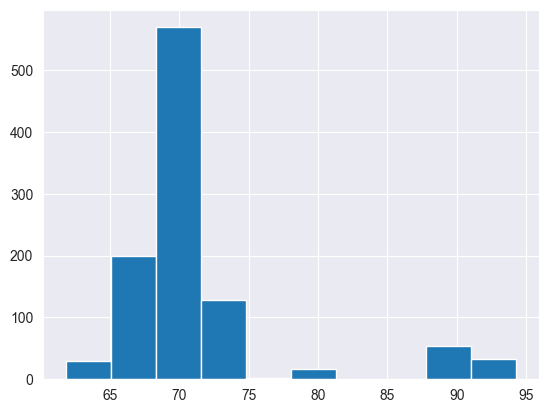

In [366]:
val_data_with_features['airtemp'].hist()

In [367]:
# val_data_with_features = val_data_with_features[['longitude', 'latitude', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06','B07', 'B08', 'B8A', 'B11', 'B12']]
copy_val_data = val_data_with_features[['airtemp', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08',
       'B8A', 'B11', 'B12']].copy()
pred_vals = pipeline.predict(copy_val_data)

In [368]:
data_to_send = pd.DataFrame()
data_to_send['UHI Index'] = pred_vals
data_to_send['Latitude'] = sub_temp['latitude']
data_to_send['Longitude'] = sub_temp['longitude']

data_to_send = data_to_send[['Longitude', 'Latitude', 'UHI Index']]
data_to_send.to_csv('../outputs/predicted_values_airtemp.csv', index=False)

In [369]:
data_to_send

,Longitude,Latitude,UHI Index
0,-73.971665,40.788763,1.008214
1,-73.971928,40.788875,1.028212
2,-73.967080,40.789080,1.008344
3,-73.972550,40.789082,1.025402
4,-73.969697,40.787953,1.007994
...,...,...,...
1035,-73.919388,40.813803,1.008120
1036,-73.931033,40.833178,1.024134
1037,-73.934647,40.854542,1.041228
1038,-73.917223,40.815413,1.039064


(array([  4.,   4.,   1.,   8.,  15.,  22.,  32.,  32.,  32.,  40.,  48.,
         69.,  94.,  65.,  72.,  67.,  88., 124.,  60.,  44.,  35.,  29.,
         14.,   9.,  11.,  11.,   4.,   2.,   3.,   1.]),
 array([0.95720342, 0.96015249, 0.96310155, 0.96605061, 0.96899968,
        0.97194874, 0.9748978 , 0.97784686, 0.98079593, 0.98374499,
        0.98669405, 0.98964312, 0.99259218, 0.99554124, 0.99849031,
        1.00143937, 1.00438843, 1.0073375 , 1.01028656, 1.01323562,
        1.01618469, 1.01913375, 1.02208281, 1.02503188, 1.02798094,
        1.03093   , 1.03387907, 1.03682813, 1.03977719, 1.04272626,
        1.04567532]),
 <BarContainer object of 30 artists>)

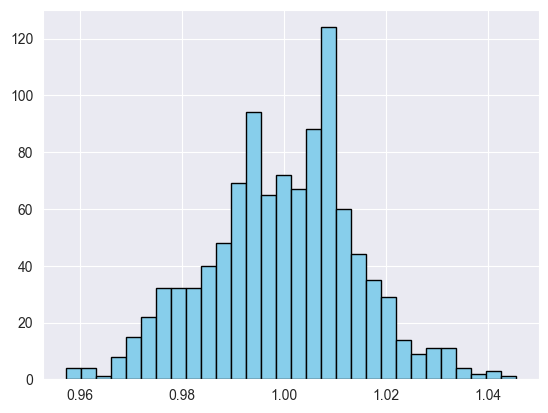

In [78]:
plt.hist(data_to_send['UHI Index'], bins=30, color='skyblue', edgecolor='black')

In [33]:
global_data = pd.read_csv('../data/GlobalLandTemperaturesByCity.csv')

In [34]:
global_data_1 = global_data[global_data['City'] == 'New York']

In [35]:
global_data_1

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
5203973,1743-11-01,3.264,1.665,New York,United States,40.99N,74.56W
5203974,1743-12-01,NaN,NaN,New York,United States,40.99N,74.56W
5203975,1744-01-01,NaN,NaN,New York,United States,40.99N,74.56W
5203976,1744-02-01,NaN,NaN,New York,United States,40.99N,74.56W
5203977,1744-03-01,NaN,NaN,New York,United States,40.99N,74.56W
...,...,...,...,...,...,...,...
5207207,2013-05-01,15.544,0.281,New York,United States,40.99N,74.56W
5207208,2013-06-01,20.892,0.273,New York,United States,40.99N,74.56W
5207209,2013-07-01,24.722,0.279,New York,United States,40.99N,74.56W
5207210,2013-08-01,21.001,0.323,New York,United States,40.99N,74.56W


In [71]:
poly_pred_vals = pd.read_csv('../outputs/poly_predicted_values.csv')
tree_pred_vals = pd.read_csv('../outputs/predicted_values.csv')

In [80]:
differences = tree_pred_vals - poly_pred_vals
differences.std()

Longitude    0.0
Latitude     0.0
UHI Index    0.0
dtype: float64

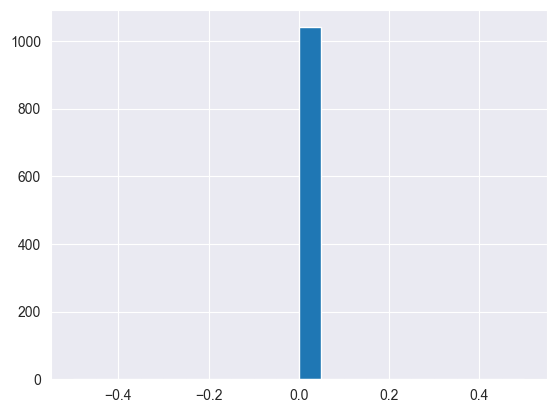

In [77]:
differences['UHI Index'].hist(bins = 20)
plt.show()

In [81]:
df_clean_factor_temp

NameError: name 'df_clean_factor_temp' is not defined

Columns: ['longitude', 'latitude', 'UHI Index', 'spatial_ref', 'B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B11', 'B12', 'distance', 'distance_meters', 'NDVI', 'SAVI', 'NDBI', 'MNDWI', 'EVI', 'day', 'airtemp']
Inside remove_outliers_iqr, initial shape: (11229, 5)
Comparison of methods:
   outlier_method imputation_method  avg_abs_corr_with_target  n_samples
0            none              none                  0.248976      11229
1            none              mean                  0.248976      11229
2            none            median                  0.248976      11229
3            none               knn                  0.248976      11229
4            none         iterative                  0.248976      11229
32      winsorize            median                  0.248511      11229
30      winsorize              none                  0.248511      11229
34      winsorize         iterative                  0.248511      11229
33      winsorize               knn  

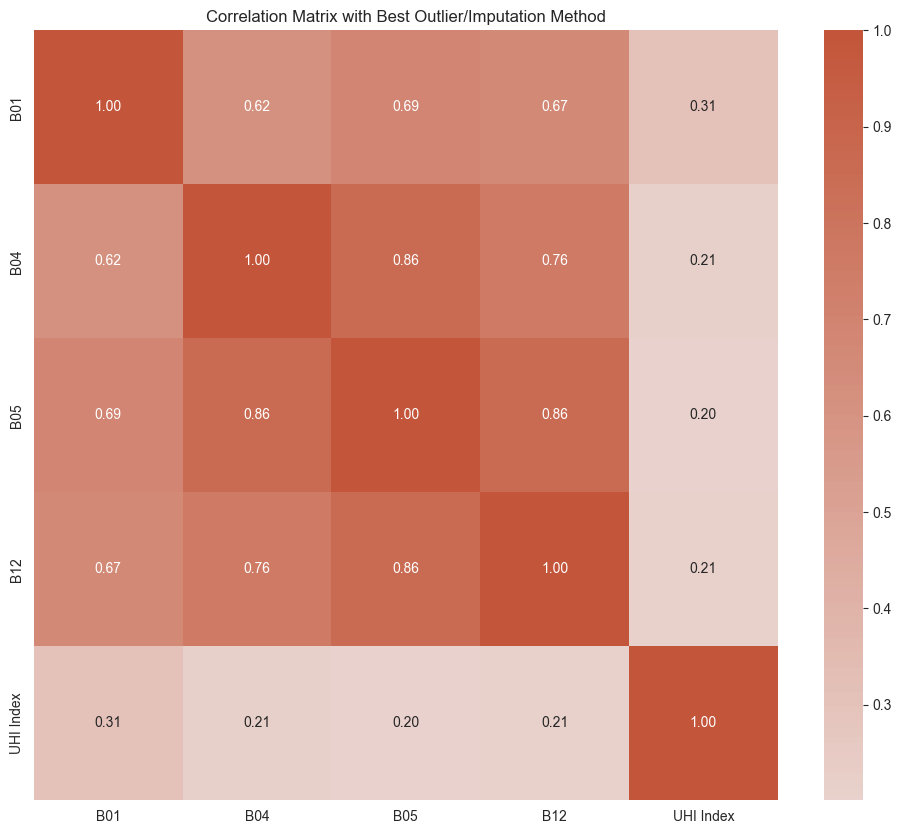

In [119]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer, IterativeImputer
from scipy.stats import median_abs_deviation
import seaborn as sns
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# Load dataset
# ------------------------------------------------------------
df_orig = pd.read_csv("../data/training_data_with_features_corr.csv")
print("Columns:", df_orig.columns.tolist())

# We'll assume the target column is "UHI Index"
target = "UHI Index"

# Drop non-numeric columns (e.g., datetime, day, etc.)
cols_to_drop = ["datetime", "time", "spatial_ref", "EVI", "day"]
df = df_orig.drop(columns=cols_to_drop, errors="ignore").copy()

# (Optional) If you want to use only a subset of features (for example, ['B01', 'B04','B05', 'B12']),
# uncomment the following lines:
cols_to_keep = ['B01', 'B04', 'B05', 'B12', target]
df = df[cols_to_keep].copy()

# Force conversion of all columns except target to numeric (non-convertible become NaN)
for col in df.columns:
    if col != target:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# ------------------------------------------------------------
# Outlier Removal Functions
# ------------------------------------------------------------
def remove_outliers_iqr(df, factor=3):
    """Custom function: Drop rows with any numeric feature out of [Q1 - factor*IQR, Q3 + factor*IQR]."""
    print("Inside remove_outliers_iqr, initial shape:", df.shape)
    df.reset_index(drop=True, inplace=True)
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

def remove_outliers_iqr_drop(df, factor=3):
    """Drop rows with any numeric feature out of [Q1 - factor*IQR, Q3 + factor*IQR]."""
    df_clean = df.copy().reset_index(drop=True)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

def remove_outliers_iqr_nan(df, factor=3):
    """Replace outliers with NaN using IQR method for numeric columns (except target)."""
    df_mod = df.copy()
    numeric_cols = df_mod.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        Q1 = df_mod[col].quantile(0.25)
        Q3 = df_mod[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        df_mod.loc[(df_mod[col] < lower_bound) | (df_mod[col] > upper_bound), col] = np.nan
    return df_mod

def remove_outliers_zscore_drop(df, threshold=4):
    """Drop rows with any numeric feature with robust z-score above threshold."""
    df_clean = df.copy().reset_index(drop=True)
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        med = df_clean[col].median()
        mad = median_abs_deviation(df_clean[col], scale='normal')
        if mad == 0:
            continue
        z = (df_clean[col] - med) / mad
        df_clean = df_clean[(np.abs(z) <= threshold)]
    return df_clean

def remove_outliers_zscore_nan(df, threshold=3):
    """Replace values with NaN if their robust z-score exceeds threshold."""
    df_mod = df.copy()
    numeric_cols = df_mod.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        med = df_mod[col].median()
        mad = median_abs_deviation(df_mod[col], scale='normal')
        if mad == 0:
            continue
        z = (df_mod[col] - med) / mad
        df_mod.loc[np.abs(z) > threshold, col] = np.nan
    return df_mod

def winsorize_df(df, lower_quantile=0.05, upper_quantile=0.95):
    """Winsorize each numeric column (except target) by clipping at given quantiles."""
    df_mod = df.copy()
    numeric_cols = df_mod.select_dtypes(include=[np.number]).columns.tolist()
    numeric_cols = [col for col in numeric_cols if col != target]
    for col in numeric_cols:
        lower = df_mod[col].quantile(lower_quantile)
        upper = df_mod[col].quantile(upper_quantile)
        df_mod[col] = df_mod[col].clip(lower, upper)
    return df_mod

# ------------------------------------------------------------
# Define Imputation Functions (without MissForest)
# ------------------------------------------------------------
def impute_mean(df):
    return df.fillna(df.mean())

def impute_median(df):
    return df.fillna(df.median())

def impute_knn(df, n_neighbors=5):
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=n_neighbors)
    if df.shape[0] == 0:
        return df
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed

def impute_iterative(df):
    from sklearn.experimental import enable_iterative_imputer  # noqa
    from sklearn.impute import IterativeImputer
    imputer = IterativeImputer(random_state=42)
    if df.shape[0] == 0:
        return df
    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns, index=df.index)
    return df_imputed

# ------------------------------------------------------------
# Iterate over combinations of outlier removal and imputation methods,
# then compute correlation matrix and report average absolute correlation
# between each feature and the target variable.
# ------------------------------------------------------------
outlier_methods = {
    "none": lambda df: df.copy(),
    "iqr": remove_outliers_iqr,          # the new function (prints df and resets index)
    "iqr_drop": remove_outliers_iqr_drop,
    "iqr_nan": remove_outliers_iqr_nan,
    "zscore_drop": remove_outliers_zscore_drop,
    "zscore_nan": remove_outliers_zscore_nan,
    "winsorize": winsorize_df
}

imputation_methods = {
    "none": lambda df: df.copy(),  # no imputation
    "mean": impute_mean,
    "median": impute_median,
    "knn": impute_knn,
    "iterative": impute_iterative
}

results = []

# We'll work only on the numeric DataFrame (including target)
df_numeric = df.copy()
df_numeric = df_numeric.apply(pd.to_numeric, errors='coerce')

for outlier_name, outlier_func in outlier_methods.items():
    df_out = outlier_func(df_numeric)
    for imp_name, imp_func in imputation_methods.items():
        df_imp = imp_func(df_out)
        # Skip if resulting DataFrame is empty
        if df_imp.shape[0] == 0:
            continue
        # Drop any remaining rows with missing target values
        df_imp = df_imp.dropna(subset=[target])
        if df_imp.shape[0] == 0:
            continue
        corr = df_imp.corr(method='spearman')
        if target in corr.columns:
            corr_target = corr[target].drop(target)
            avg_abs_corr = np.mean(np.abs(corr_target))
        else:
            avg_abs_corr = np.nan
        results.append({
            "outlier_method": outlier_name,
            "imputation_method": imp_name,
            "avg_abs_corr_with_target": avg_abs_corr,
            "n_samples": df_imp.shape[0]
        })

results_df = pd.DataFrame(results)
print("Comparison of methods:")
print(results_df.sort_values("avg_abs_corr_with_target", ascending=False))

# Optionally, plot the correlation matrix for the best combination:
best = results_df.sort_values("avg_abs_corr_with_target", ascending=False).iloc[0]
print("Best combination:", best)

# For example, using median imputation after IQR (with NaN replacement):
best_df = impute_median(remove_outliers_iqr_nan(df_numeric))
corr_best = best_df.corr(method='spearman')

plt.figure(figsize=(12,10))
sns.heatmap(corr_best, cmap=sns.diverging_palette(220, 20, as_cmap=True), annot=True, fmt=".2f", center=0)
plt.title("Correlation Matrix with Best Outlier/Imputation Method")
plt.show()


In [161]:
import pandas as pd
import joblib
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, SelectKBest, f_regression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assume df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data into training and testing sets (25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build a Pipeline
# ------------------------------
# The pipeline includes optional preprocessing steps and then a model.
# By default, these steps are set to "passthrough" so that GridSearchCV can decide.
pipeline = Pipeline([
    ("variance_threshold", "passthrough"),
    ("select_from_model", "passthrough"),
    ("select_kbest", "passthrough"),
    ("scaler", StandardScaler()),
    ("model", ExtraTreesRegressor(random_state=42))
])

# ------------------------------
# 3. Define Parameter Grid for Multiple Models
# ------------------------------
param_grid = [
    {   # ExtraTreesRegressor settings
        "variance_threshold": [VarianceThreshold(threshold=0.001), VarianceThreshold(threshold=0.01), "passthrough"],
        "select_from_model": [
            SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=300, random_state=42), threshold="mean"),
            SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=300, random_state=42), threshold="0.99*mean"),
            "passthrough"
        ],
        "select_kbest": [SelectKBest(score_func=f_regression, k=5), "passthrough"],
        "scaler": [StandardScaler(), RobustScaler(), MinMaxScaler(), QuantileTransformer(n_quantiles=100, output_distribution='normal'), "passthrough"],
        "model": [ExtraTreesRegressor(random_state=42)],
        "model__n_estimators": [300, 600, 900],
        "model__max_depth": [None, 50, 100],
        "model__min_samples_split": [2, 3, 4],
        "model__max_features": ["sqrt", "log2", None]
    },
    {   # RandomForestRegressor settings
        "variance_threshold": [VarianceThreshold(threshold=0.01), "passthrough"],
        "select_from_model": [
            SelectFromModel(estimator=RandomForestRegressor(n_estimators=300, random_state=42), threshold="mean"),
            "passthrough"
        ],
        "select_kbest": [SelectKBest(score_func=f_regression, k=5), "passthrough"],
        "scaler": [StandardScaler(), RobustScaler()],
        "model": [RandomForestRegressor(random_state=42)],
        "model__n_estimators": [300, 600],
        "model__max_depth": [None, 50, 100],
        "model__min_samples_split": [2, 3],
        "model__max_features": ["sqrt", "log2", None]
    },
    {   # GradientBoostingRegressor settings
        "variance_threshold": ["passthrough"],
        "select_from_model": ["passthrough"],
        "select_kbest": [SelectKBest(score_func=f_regression, k=5), "passthrough"],
        "scaler": [StandardScaler(), RobustScaler(), "passthrough"],
        "model": [GradientBoostingRegressor(random_state=42)],
        "model__n_estimators": [300, 600],
        "model__max_depth": [3, 5, 7],
        "model__min_samples_split": [2, 3]
    },
    {   # XGBRegressor settings (XGBoost)
        "variance_threshold": ["passthrough"],
        "select_from_model": ["passthrough"],
        "select_kbest": ["passthrough"],
        "scaler": [StandardScaler(), RobustScaler(), "passthrough"],
        "model": [XGBRegressor(random_state=42, objective='reg:squarederror')],
        "model__n_estimators": [300, 600],
        "model__max_depth": [3, 5, 7],
        "model__learning_rate": [0.01, 0.1],
        "model__subsample": [0.8, 1.0]
    }
]

# ------------------------------
# 4. Run GridSearchCV with Verbose Output
# ------------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=3  # Verbose to get real-time output
)

print("Running GridSearchCV on the robust pipeline...")
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best CV R²: {:.4f}".format(grid_search.best_score_))

# ------------------------------
# 5. Evaluate on Test Set
# ------------------------------
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# ------------------------------
# 6. Refit on Entire Dataset and Save the Pipeline
# ------------------------------
best_pipeline.fit(X, y)
model_filename = "trained_model_pipeline_robust_multi.pkl"
joblib.dump(best_pipeline, model_filename)
print("Pipeline saved as:", model_filename)


Running GridSearchCV on the robust pipeline...
Fitting 5 folds for each of 8010 candidates, totalling 40050 fits
Best parameters found:
{'model': ExtraTreesRegressor(random_state=42), 'model__max_depth': None, 'model__max_features': None, 'model__min_samples_split': 2, 'model__n_estimators': 900, 'scaler': RobustScaler(), 'select_from_model': SelectFromModel(estimator=ExtraTreesRegressor(n_estimators=300,
                                              random_state=42),
                threshold='mean'), 'select_kbest': SelectKBest(k=5, score_func=<function f_regression at 0x000002D29472DAB0>), 'variance_threshold': VarianceThreshold(threshold=0.001)}
Best CV R²: 0.6979
Test R²: 0.7947
Test MAPE: 0.41%
Pipeline saved as: trained_model_pipeline_robust_multi.pkl


In [149]:
import pandas as pd
import joblib
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assume df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data into training and testing sets (25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build the Pipeline
# ------------------------------
# The pipeline uses a scaler and then the XGBRegressor.
pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBRegressor(random_state=42, objective='reg:squarederror'))
])

# ------------------------------
# 3. Define a Refined Hyperparameter Grid for XGBRegressor
# ------------------------------
param_grid = {
    "model__n_estimators": [300, 500, 700],
    "model__max_depth": [3, 7, 10],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.9, 1.0],
    "model__gamma": [0.1, 0.3, 0.5],
    "model__reg_alpha": [0.01, 0.1],
    "model__reg_lambda": [1, 2],
    "model__min_child_weight": [1, 3]
}

# ------------------------------
# 4. Run GridSearchCV with Verbose Output
# ------------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    scoring="r2",
    n_jobs=-1,
    verbose=3  # This level prints detailed progress information in real-time.
)

print("Running GridSearchCV for XGBRegressor with refined hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best CV R²: {:.4f}".format(grid_search.best_score_))

# ------------------------------
# 5. Evaluate on Test Set
# ------------------------------
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# ------------------------------
# 6. Refit on Entire Dataset and Save the Pipeline
# ------------------------------
best_pipeline.fit(X, y)
model_filename = "trained_xgb_pipeline_refined.pkl"
joblib.dump(best_pipeline, model_filename)
print("Pipeline saved as:", model_filename)


Running GridSearchCV for XGBRegressor with refined hyperparameter tuning...
Fitting 3 folds for each of 5832 candidates, totalling 17496 fits
Best parameters found:
{'model__colsample_bytree': 0.7, 'model__gamma': 0.1, 'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__min_child_weight': 1, 'model__n_estimators': 300, 'model__reg_alpha': 0.01, 'model__reg_lambda': 1, 'model__subsample': 0.7}
Best CV R²: nan


AttributeError: 'super' object has no attribute '__sklearn_tags__'

In [152]:
import pandas as pd
import numpy as np
import joblib
import sklearn
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.impute import SimpleImputer

# Disable metadata routing to avoid tag issues
sklearn.set_config(enable_metadata_routing=False)

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assume df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data (25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build the Pipeline
# ------------------------------
# The pipeline now includes:
#   - SelectFromModel: to select features based on importance.
#   - SimpleImputer: to fill missing values (median strategy).
#   - Scaler: RobustScaler.
#   - Model: XGBRegressor with fixed best hyperparameters.
pipeline = Pipeline([
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.99*mean"
    )),
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler()),
    ("model", XGBRegressor(
        random_state=42,
        objective='reg:squarederror',
        n_estimators=300,
        max_depth=3,
        learning_rate=0.01,
        subsample=0.7,
        colsample_bytree=0.7,
        gamma=0.1,
        reg_alpha=0.01,
        reg_lambda=1,
        min_child_weight=1
    ))
])

# ------------------------------
# 3. Define a Refined Hyperparameter Grid for XGBRegressor
# ------------------------------
param_grid = {
    "model__n_estimators": [300, 500, 700],
    "model__max_depth": [3, 5, 7, 10],
    "model__learning_rate": [0.01, 0.05, 0.1],
    "model__subsample": [0.7, 0.8, 0.9, 1.0],
    "model__colsample_bytree": [0.7, 0.8, 0.9, 1.0],
    "model__gamma": [0, 0.1, 0.3, 0.5],
    "model__reg_alpha": [0, 0.01, 0.1],
    "model__reg_lambda": [1, 1.5, 2],
    "model__min_child_weight": [1, 3, 5]
}

# ------------------------------
# 4. Run GridSearchCV with Verbose Output and Error Score Handling
# ------------------------------
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring="r2",
    n_jobs=-1,
    verbose=3,
    error_score=-np.inf  # Penalize configurations that fail (or yield constant predictions)
)

print("Running GridSearchCV for XGBRegressor with refined hyperparameter tuning...")
grid_search.fit(X_train, y_train)

print("Best parameters found:")
print(grid_search.best_params_)
print("Best CV R²: {:.4f}".format(grid_search.best_score_))

# ------------------------------
# 5. Evaluate on Test Set
# ------------------------------
best_pipeline = grid_search.best_estimator_
y_pred = best_pipeline.predict(X_test)
print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# ------------------------------
# 6. Refit on Entire Dataset and Save the Pipeline
# ------------------------------
best_pipeline.fit(X, y)
model_filename = "trained_xgb_pipeline_refined.pkl"
joblib.dump(best_pipeline, model_filename)
print("Pipeline saved as:", model_filename)


Running GridSearchCV for XGBRegressor with refined hyperparameter tuning...
Fitting 5 folds for each of 62208 candidates, totalling 311040 fits


KeyboardInterrupt: 

In [158]:
import pandas as pd
import joblib
from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from scipy.stats import randint, uniform

# ------------------------------
# 1. Load Data and Preprocessing
# ------------------------------
# Assume df_clean_factor3 is your preprocessed DataFrame
data = df_clean_factor3.copy()

# Drop irrelevant columns
cols_to_drop = ["latitude", "longitude", "datetime", "distance", "distance_meters", "time", "spatial_ref", "EVI"]
data = data.drop(columns=cols_to_drop, errors="ignore")

# Define target variable
target = "UHI Index"
X = data.drop(target, axis=1)
y = data[target]

# Split data into training and testing sets (25% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# ------------------------------
# 2. Build the Pipeline
# ------------------------------
pipeline = Pipeline([
    ("select_from_model", SelectFromModel(
        estimator=ExtraTreesRegressor(n_estimators=300, random_state=42),
        threshold="0.99*mean"
    )),
    ("scaler", RobustScaler()),
    ("model", XGBRegressor(
        random_state=42,
        objective='reg:squarederror'
    ))
])

# ------------------------------
# 3. Define Hyperparameter Grid for Tuning
# ------------------------------
param_grid = {
    "model__n_estimators": randint(100, 1000),  # Number of trees
    "model__max_depth": randint(3, 50),       # Maximum depth of a tree
    "model__learning_rate": uniform(0.01, 0.3),  # Learning rate
    "model__subsample": uniform(0.6, 0.1),    # Subsample ratio of the training instances
    "model__colsample_bytree": uniform(0.6, 0.1),  # Subsample ratio of columns
    "model__gamma": uniform(0, 0.1),          # Minimum loss reduction to make a split
    "model__reg_alpha": uniform(0, 1),        # L1 regularization term
    "model__reg_lambda": uniform(0, 1),       # L2 regularization term
    "model__min_child_weight": randint(1, 10)  # Minimum sum of instance weight needed in a child
}

# ------------------------------
# 4. Perform Randomized Search for Hyperparameter Tuning
# ------------------------------
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=200,  # Number of parameter settings to sample
    scoring="neg_mean_absolute_percentage_error",  # Metric to optimize
    cv=5,  # 5-fold cross-validation
    verbose=2,  # Print progress
    random_state=42,
    n_jobs=-1  # Use all available cores
)

print("Performing randomized search for hyperparameter tuning...")
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation score (MAPE):", -random_search.best_score_)

# ------------------------------
# 5. Evaluate the Best Model on the Test Set
# ------------------------------
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Test R²: {:.4f}".format(r2_score(y_test, y_pred)))
print("Test MAPE: {:.2f}%".format(mean_absolute_percentage_error(y_test, y_pred) * 100))

# ------------------------------
# 6. Refit on Entire Dataset and Save the Pipeline
# ------------------------------
best_model.fit(X, y)
model_filename = "trained_xgb_pipeline_tuned.pkl"
joblib.dump(best_model, model_filename)
print("Tuned pipeline saved as:", model_filename)

Performing randomized search for hyperparameter tuning...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters found: {'model__colsample_bytree': np.float64(0.9746592607422829), 'model__gamma': np.float64(0.019593163337823127), 'model__learning_rate': np.float64(0.13538380951467363), 'model__max_depth': 7, 'model__min_child_weight': 9, 'model__n_estimators': 263, 'model__reg_alpha': np.float64(0.17743954377972282), 'model__reg_lambda': np.float64(0.7506147516408583), 'model__subsample': np.float64(0.9227338957069056)}
Best cross-validation score (MAPE): 0.012661456112772848


AttributeError: 'super' object has no attribute '__sklearn_tags__'